# Tworzenie modelu predykcyjnego w oparciu o dane z lat 2010-2012

In [1]:
#import bibliotek
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency
import scipy.stats as stats


import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
#import danych z pliku csv
df = pd.read_csv("loan_do_predykcji_2010_2012.csv", low_memory=False)

In [3]:
#sprawdzenie czy się zaimportowało właściwie i ogólny przegląd tabeli i wartości
df.shape

(86624, 143)

In [4]:
#interesują nas jedynie statusy 'Fully Paid' oraz 'Charged Off' i dane zostały ograniczone do tych wartości
df['loan_status'].value_counts()

Fully Paid     73196
Charged Off    13428
Name: loan_status, dtype: int64

In [5]:
#kopia zapasowa i kształt tabeli po zostawieniu interesujących nas statusów w kolumnie 'loan_status'
df1 = df
df1.shape

(86624, 143)

In [6]:
#sprawdzenie czy występują kolumny gdzie brakuje wartości
df1.isna().sum()

Unnamed: 0                                        0
id                                                0
loan_amnt                                         0
funded_amnt                                       0
funded_amnt_inv                                   0
                                              ...  
orig_projected_additional_accrued_interest    86621
hardship_payoff_balance_amount                86619
hardship_last_payment_amount                  86619
debt_settlement_flag                              0
year                                              0
Length: 143, dtype: int64

In [7]:
#procentowy udział wierszy w których brakuje wartości w kolumnie
df2 = round(100*(df1.isna().sum()/len(df1.id)), 2)
df2.loc[df2 > 0]

emp_title                                       6.09
emp_length                                      3.47
title                                           0.01
mths_since_last_delinq                         61.53
mths_since_last_record                         96.24
                                               ...  
hardship_dpd                                   99.99
hardship_loan_status                           99.99
orig_projected_additional_accrued_interest    100.00
hardship_payoff_balance_amount                 99.99
hardship_last_payment_amount                   99.99
Length: 88, dtype: float64

In [8]:
#są kolumny gdzie większości danych brakuje - jeśli próg ustawimy na 70% lub więcej brakujących danych to 
#do usunięcia jest 71 kolumn
df1_puste = list(df2[df2 >= 70].index)
len(df1_puste)

71

In [9]:
#usunięcie kolumn gdzie brakuje wartości w wierszach wg wskazanego progu
df2 = df1.drop(df1_puste,axis=1)

In [10]:
df2.shape

(86624, 72)

In [11]:
#w kolejnym kroku wylistujemy kolumny wraz z liczbą unikalnych wartości
df2.nunique()

Unnamed: 0              86624
id                      86624
loan_amnt                1122
funded_amnt              1163
funded_amnt_inv          5653
                        ...  
total_bal_ex_mort       34983
total_bc_limit           4197
hardship_flag               1
debt_settlement_flag        2
year                        3
Length: 72, dtype: int64

In [12]:
#kolumny gdzie występuje tylko jedna unikalna wartość nie przydazą się w modelowaniu, dlatego trzeba się ich pozbyć
#tworzymy listę kolumn z tylko jedną unikalną wartością
df_unikalne = df2.nunique()
df_unikalne = list(df_unikalne[df_unikalne == 1].index)
df_unikalne

['pymnt_plan',
 'out_prncp',
 'out_prncp_inv',
 'policy_code',
 'application_type',
 'hardship_flag']

In [13]:
#usuwamy kolumny z listy powyżej
df3 = df2.drop(columns = df_unikalne)

In [14]:
df3.shape

(86624, 66)

In [15]:
#lista kolumn do usunięcia
df_del = ['Unnamed: 0', 'zip_code', 'addr_state', 'url', 'sub_grade', 'title', 'emp_title', 'issue_d', 'total_pymnt', 
               'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
               'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 
               'funded_amnt_inv', 'debt_settlement_flag', 'last_fico_range_high', 'last_fico_range_low']

In [16]:
df_del

['Unnamed: 0',
 'zip_code',
 'addr_state',
 'url',
 'sub_grade',
 'title',
 'emp_title',
 'issue_d',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'funded_amnt_inv',
 'debt_settlement_flag',
 'last_fico_range_high',
 'last_fico_range_low']

In [17]:
df4 = df3.drop(df_del, axis = 1)

In [18]:
df4.shape

(86624, 44)

In [19]:
df4.keys()

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'acc_open_past_24mths',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_bc_sats', 'num_sats', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'total_bal_ex_mort', 'total_bc_limit', 'year'],
      dtype='object')

In [20]:
df5 = df4.drop(['id', 'year', 'acc_now_delinq', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'tax_liens', 
                'initial_list_status', 'percent_bc_gt_75', 'bc_util', 'acc_open_past_24mths', 'bc_open_to_buy'], axis = 1)

In [21]:
df5.shape

(86624, 33)

In [22]:
#ilość wierszy z brakującymi wartościami
df5.isna().sum()

loan_amnt                     0
funded_amnt                   0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_length                 3003
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
mths_since_last_delinq    53296
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   75
total_acc                     0
delinq_amnt                   0
mort_acc                  40752
mths_since_recent_bc      41205
mths_since_recent_inq     46543
num_bc_sats               49312
num_sats                  49312
pub_rec_bankruptcies          0
total_ba

In [23]:
#puste wartości w kolumnach mths_since_last_delinq oraz pub_rec_bankruptcies można uzupełnić wartością 0, 
#ponieważ wydaje się prawdopodobne, aby rozkład w społeństwie sugerował że brak danych to brak przestępstw i bankructwa 
df5['mths_since_last_delinq'] = df5['mths_since_last_delinq'].fillna(0)

In [24]:
#pozostałe wiersze z brakującymi danymi usuwamy i sprawdzamy czy tabela nie zawiera już braków danych
df6 = df5.dropna()
df6.isna().sum()

loan_amnt                 0
funded_amnt               0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
fico_range_low            0
fico_range_high           0
inq_last_6mths            0
mths_since_last_delinq    0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util                0
total_acc                 0
delinq_amnt               0
mort_acc                  0
mths_since_recent_bc      0
mths_since_recent_inq     0
num_bc_sats               0
num_sats                  0
pub_rec_bankruptcies      0
total_bal_ex_mort         0
total_bc_limit            0
dtype: int64

In [25]:
#finalny kształt tabeli z danymi po wyczyszczeniu
df6.shape

(31414, 33)

In [26]:
df6['int_rate'] = df6['int_rate'].str.rstrip('%').astype(float)

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/1095047384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['int_rate'] = df6['int_rate'].str.rstrip('%').astype(float)


In [27]:
df6['term'] = df6['term'].str.rstrip(' months').astype('int64')

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/3555481251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['term'] = df6['term'].str.rstrip(' months').astype('int64')


In [28]:
#pozostawiamy jedynie rok
df6['earliest_cr_line'] = df6['earliest_cr_line'].str.replace(r'\D', '').astype('int64')

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/3181053525.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df6['earliest_cr_line'] = df6['earliest_cr_line'].str.replace(r'\D', '').astype('int64')
C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/3181053525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['earliest_cr_line'] = df6['earliest_cr_line'].str.replace(r'\D', '').astype('int64')


In [29]:
df6['revol_util'] = df6['revol_util'].str.rstrip('%').astype('float')

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/2275648208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['revol_util'] = df6['revol_util'].str.rstrip('%').astype('float')


In [30]:
#zobaczmy teraz jak rozkladają się wartości w poszczególnych kolumnach numerycznych
df6.describe().T.round(2)

count      mean       std      min       25%  \
loan_amnt               31414.0  13648.73   8043.97  1000.00   7500.00   
funded_amnt             31414.0  13641.44   8036.05  1000.00   7500.00   
term                    31414.0     40.58      9.43    36.00     36.00   
int_rate                31414.0     14.24      4.32     6.00     11.14   
installment             31414.0    430.48    245.52    30.44    246.40   
annual_inc              31414.0  71565.16  67112.29  5000.00  45000.00   
dti                     31414.0     17.67      7.81     0.00     11.78   
delinq_2yrs             31414.0      0.24      0.69     0.00      0.00   
earliest_cr_line        31414.0   1997.58      6.62  1958.00   1994.00   
fico_range_low          31414.0    697.25     30.72   660.00    675.00   
fico_range_high         31414.0    701.25     30.72   664.00    679.00   
inq_last_6mths          31414.0      0.96      1.03     0.00      0.00   
mths_since_last_delinq  31414.0     16.52     23.09     0.00      0.00   
open_acc                31414.0     11.26      4.54     2.00      8.00   
pub_rec                 31414.0      0.03      0.18     0.00      0.00   
revol_bal               31414.0  15499.55  15574.39     0.00   6991.00   
revol_util              31414.0     58.32     23.24     0.00     42.40   
total_acc               31414.0     24.78     11.07     3.00     17.00   
delinq_amnt             31414.0      3.87    410.89     0.00      0.00   
mort_acc                31414.0      1.70      2.20     0.00      0.00   
mths_since_recent_bc    31414.0     23.42     27.81     0.00      6.00   
mths_since_recent_inq   31414.0      6.64      5.92     0.00      2.00   
num_bc_sats             31414.0      4.70      2.45     0.00      3.00   
num_sats                31414.0     11.24      4.53     1.00      8.00   
pub_rec_bankruptcies    31414.0      0.02      0.15     0.00      0.00   
total_bal_ex_mort       31414.0  42582.07  37524.05     0.00  19480.00   
total_bc_limit          31414.0  19538.10  18191.47     0.00   7600.00   

                             50%       75%         max  
loan_amnt               12000.00  18725.00    35000.00  
funded_amnt             12000.00  18693.75    35000.00  
term                       36.00     36.00       60.00  
int_rate                   14.09     17.27       24.89  
installment               390.34    558.48     1388.45  
annual_inc              60000.00  85000.00  7141778.00  
dti                        17.48     23.45       34.99  
delinq_2yrs                 0.00      0.00       18.00  
earliest_cr_line         1999.00   2002.00     2009.00  
fico_range_low            690.00    710.00      845.00  
fico_range_high           694.00    714.00      850.00  
inq_last_6mths              1.00      2.00        8.00  
mths_since_last_delinq      0.00     30.00      152.00  
open_acc                   11.00     14.00       46.00  
pub_rec                     0.00      0.00        5.00  
revol_bal               12085.00  19965.00   975800.00  
revol_util                 60.80     76.90      104.40  
total_acc                  23.00     31.00       99.00  
delinq_amnt                 0.00      0.00    65000.00  
mort_acc                    1.00      3.00       24.00  
mths_since_recent_bc       13.00     30.00      538.00  
mths_since_recent_inq       5.00     10.00       24.00  
num_bc_sats                 4.00      6.00       32.00  
num_sats                   11.00     14.00       46.00  
pub_rec_bankruptcies        0.00      0.00        5.00  
total_bal_ex_mort       33406.50  53951.50   994496.00  
total_bc_limit          14300.00  25300.00   522210.00

array([[<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt'}>,
        <AxesSubplot:title={'center':'term'}>,
        <AxesSubplot:title={'center':'int_rate'}>,
        <AxesSubplot:title={'center':'installment'}>],
       [<AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'earliest_cr_line'}>,
        <AxesSubplot:title={'center':'fico_range_low'}>],
       [<AxesSubplot:title={'center':'fico_range_high'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'mths_since_last_delinq'}>,
        <AxesSubplot:title={'center':'open_acc'}>,
        <AxesSubplot:title={'center':'pub_rec'}>],
       [<AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'revol_util'}>,
        <AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'cen

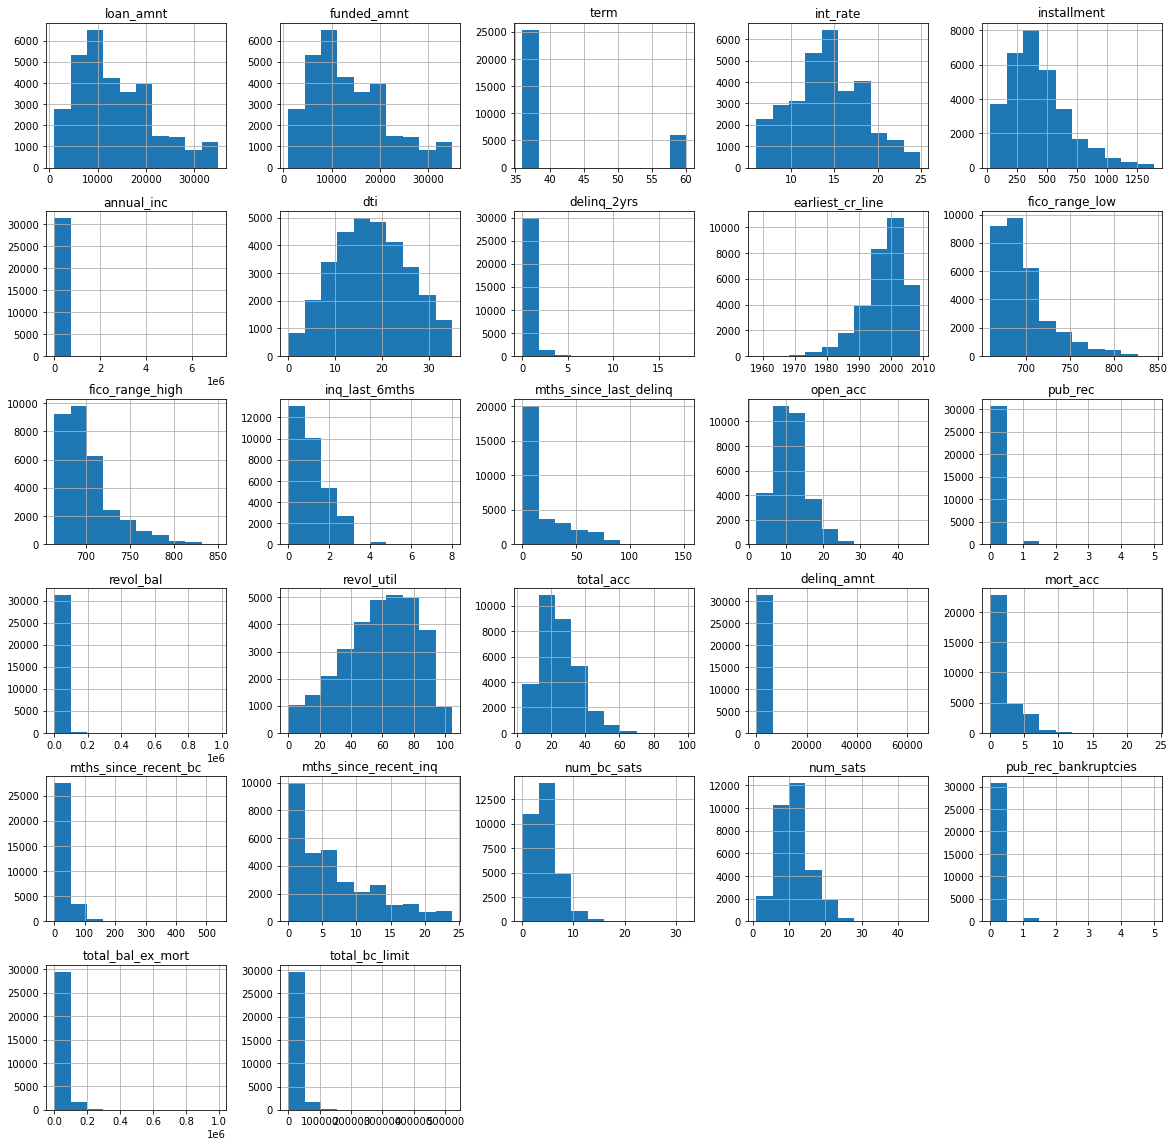

In [31]:
#histogram z rozkładem dla wszystkich kolumn numerycznych
df6.hist(figsize=(20,20))

<AxesSubplot:>

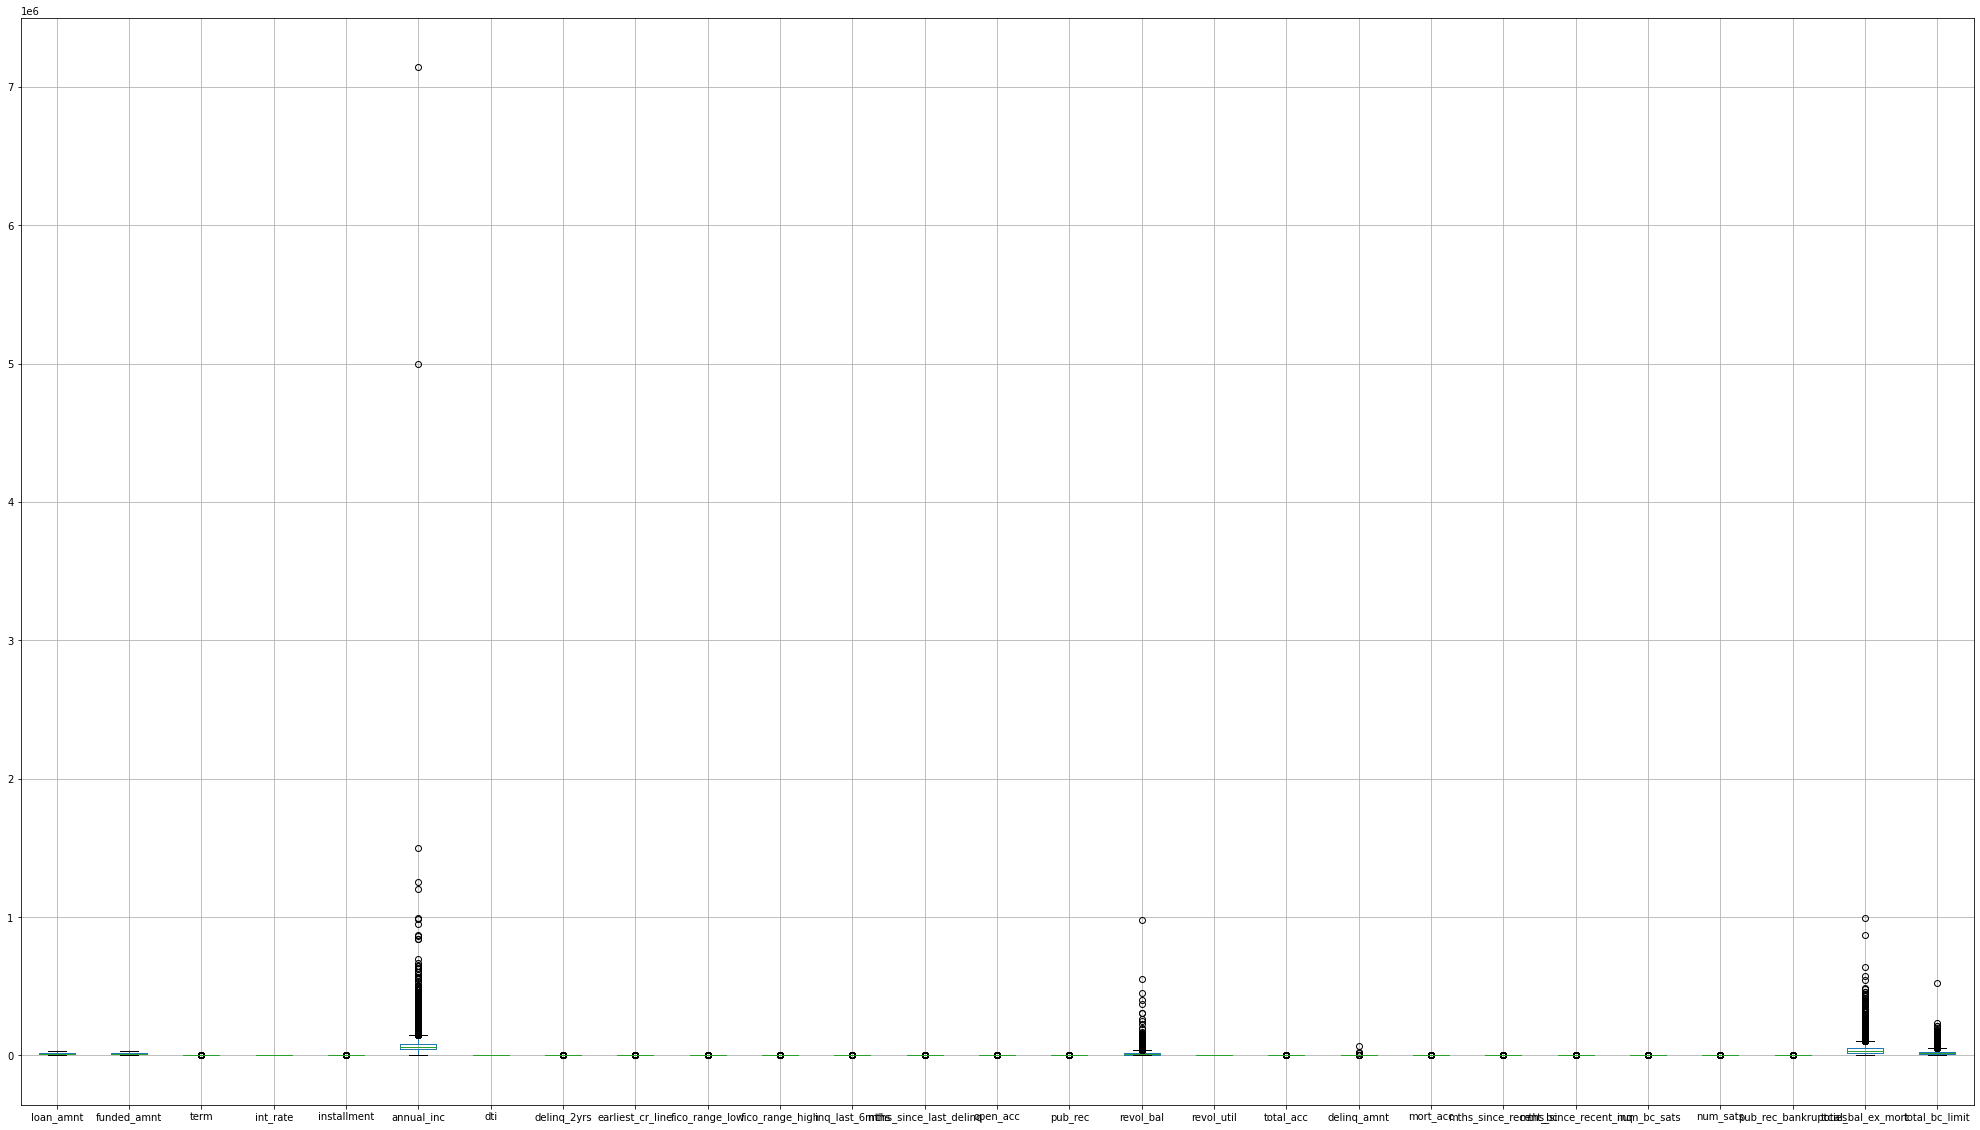

In [32]:
#sprawdzenie outliersów w kolumnach
df6.boxplot(figsize=(35,20))

In [33]:
#usunięcie outliersów z annual_inc
df7 = df6[np.abs(df6.annual_inc-df6.annual_inc.mean()) <= (3*df6.annual_inc.std())]
df7.describe()

loan_amnt   funded_amnt          term      int_rate   installment  \
count  31236.000000  31236.000000  31236.000000  31236.000000  31236.000000   
mean   13587.311916  13579.990236     40.566270     14.241497    428.603404   
std     7994.335783   7986.265587      9.420323      4.316854    243.812124   
min     1000.000000   1000.000000     36.000000      6.000000     30.440000   
25%     7475.000000   7475.000000     36.000000     11.140000    246.040000   
50%    12000.000000  12000.000000     36.000000     14.090000    388.175000   
75%    18500.000000  18500.000000     36.000000     17.270000    556.872500   
max    35000.000000  35000.000000     60.000000     24.890000   1388.450000   

          annual_inc           dti   delinq_2yrs  earliest_cr_line  \
count   31236.000000  31236.000000  31236.000000      31236.000000   
mean    69239.837165     17.726907      0.237290       1997.599853   
std     35769.483912      7.782165      0.692136          6.605942   
min      5000.000000      0.000000      0.000000       1958.000000   
25%     45000.000000     11.850000      0.000000       1994.000000   
50%     60000.000000     17.535000      0.000000       1999.000000   
75%     85000.000000     23.480000      0.000000       2002.000000   
max    270000.000000     34.990000     18.000000       2009.000000   

       fico_range_low  ...     total_acc   delinq_amnt      mort_acc  \
count    31236.000000  ...  31236.000000  31236.000000  31236.000000   
mean       697.136157  ...     24.750448      3.889647      1.688244   
std         30.628254  ...     11.057895    412.054018      2.190599   
min        660.000000  ...      3.000000      0.000000      0.000000   
25%        675.000000  ...     17.000000      0.000000      0.000000   
50%        690.000000  ...     23.000000      0.000000      1.000000   
75%        710.000000  ...     31.000000      0.000000      3.000000   
max        845.000000  ...     99.000000  65000.000000     24.000000   

       mths_since_recent_bc  mths_since_recent_inq   num_bc_sats  \
count          31236.000000           31236.000000  31236.000000   
mean              23.352862               6.644641      4.693046   
std               27.701651               5.921928      2.445559   
min                0.000000               0.000000      0.000000   
25%                6.000000               2.000000      3.000000   
50%               13.000000               5.000000      4.000000   
75%               30.000000              10.000000      6.000000   
max              538.000000              24.000000     32.000000   

           num_sats  pub_rec_bankruptcies  total_bal_ex_mort  total_bc_limit  
count  31236.000000          31236.000000       31236.000000    31236.000000  
mean      11.232552              0.022218       42145.619446    19390.329876  
std        4.524648              0.151465       35793.593870    17920.605837  
min        1.000000              0.000000           0.000000        0.000000  
25%        8.000000              0.000000       19416.750000     7600.000000  
50%       11.000000              0.000000       33262.000000    14200.000000  
75%       14.000000              0.000000       53698.500000    25200.000000  
max       46.000000              5.000000      544806.000000   522210.000000  

[8 rows x 27 columns]

<AxesSubplot:>

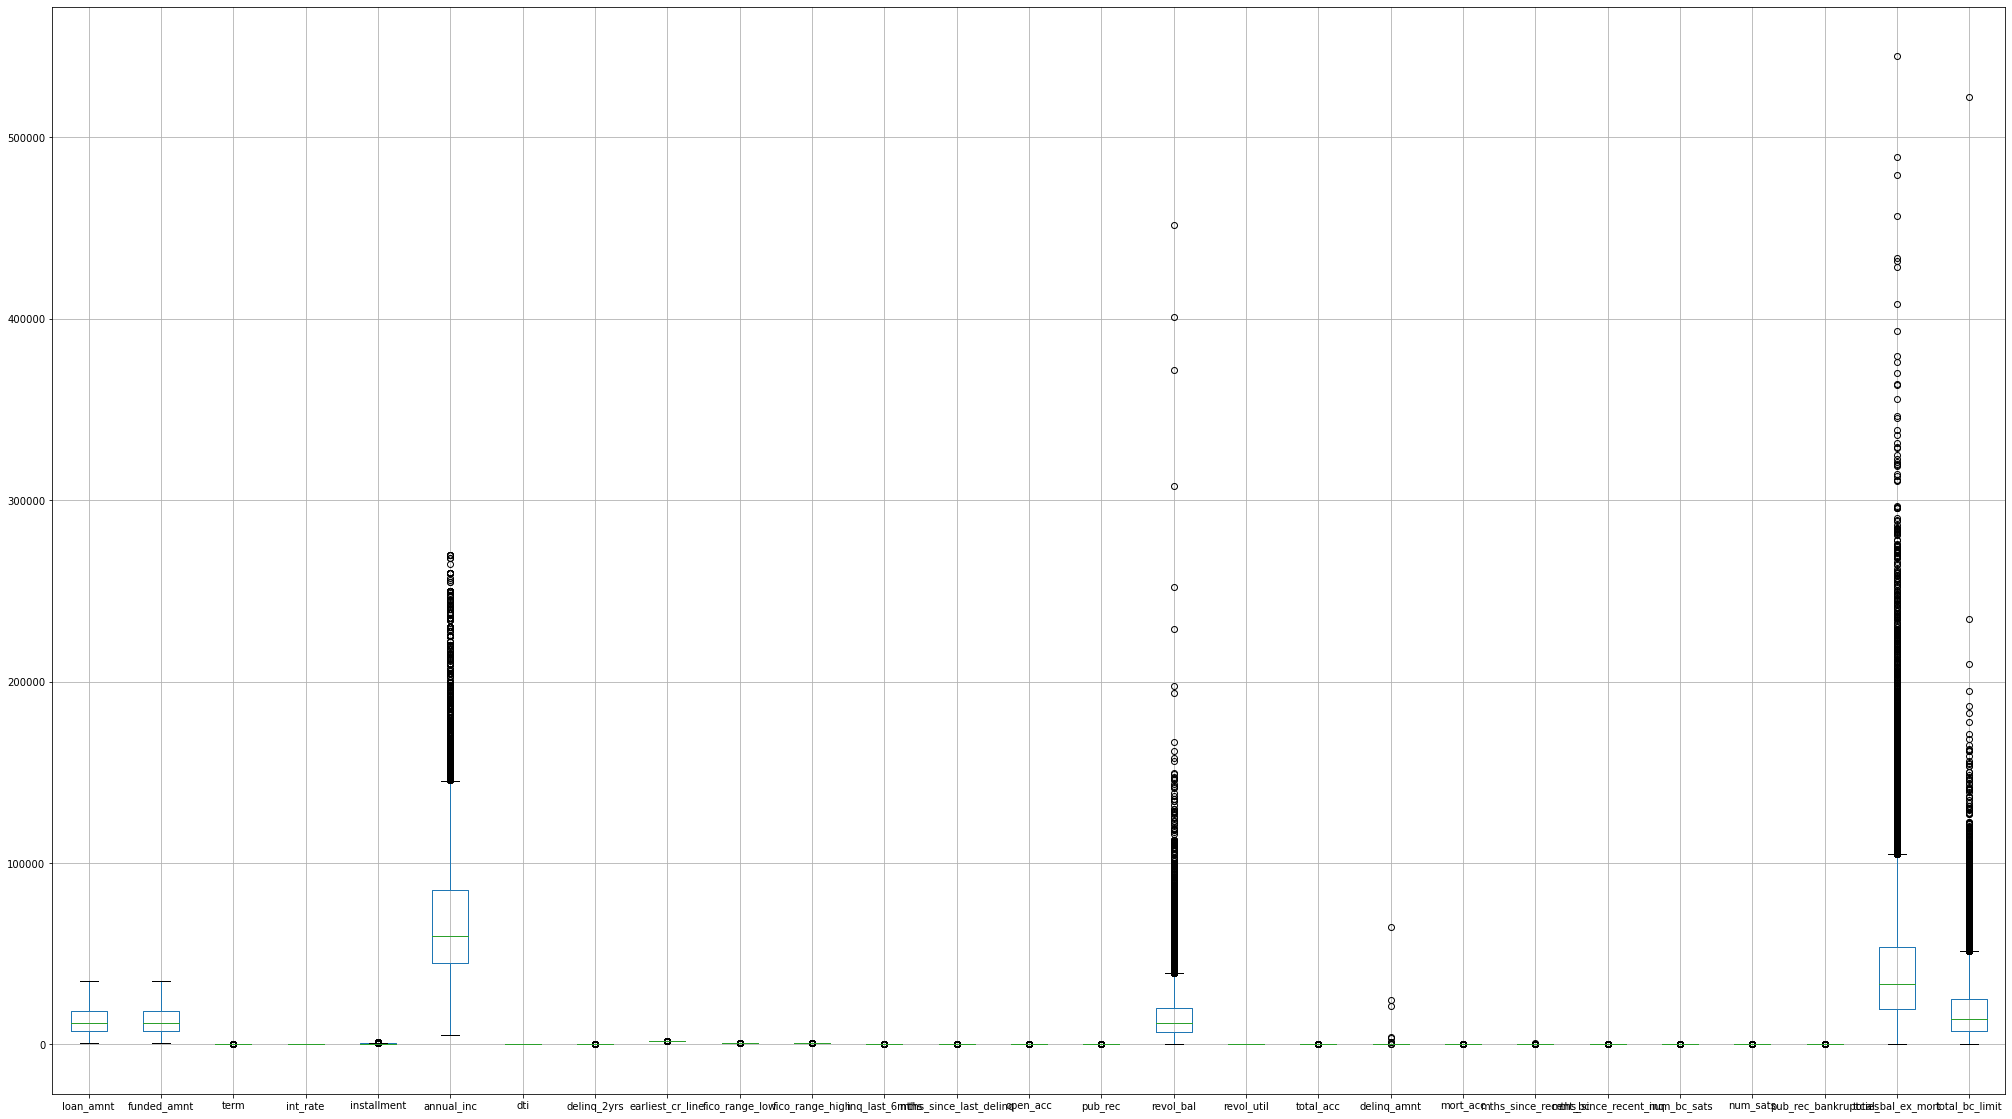

In [34]:
#ponowne spojrzenie na wartości
df7.boxplot(figsize=(35,20))

In [35]:
#sprawdzenie korelacji oraz ich mapa
df7_corr = df7.corr()
df7_corr.round(2)

loan_amnt  funded_amnt  term  int_rate  installment  \
loan_amnt                    1.00         1.00  0.48      0.37         0.96   
funded_amnt                  1.00         1.00  0.48      0.37         0.96   
term                         0.48         0.48  1.00      0.50         0.26   
int_rate                     0.37         0.37  0.50      1.00         0.36   
installment                  0.96         0.96  0.26      0.36         1.00   
annual_inc                   0.45         0.44  0.15      0.05         0.43   
dti                          0.04         0.04  0.08      0.14         0.04   
delinq_2yrs                  0.02         0.02  0.01      0.11         0.03   
earliest_cr_line            -0.21        -0.21 -0.10      0.03        -0.19   
fico_range_low               0.09         0.09  0.02     -0.67         0.01   
fico_range_high              0.09         0.09  0.02     -0.67         0.01   
inq_last_6mths               0.02         0.02  0.06      0.18         0.02   
mths_since_last_delinq       0.02         0.02  0.00      0.14         0.04   
open_acc                     0.18         0.18  0.08      0.10         0.18   
pub_rec                     -0.05        -0.05 -0.00      0.03        -0.05   
revol_bal                    0.37         0.37  0.16      0.12         0.36   
revol_util                   0.09         0.09  0.06      0.47         0.13   
total_acc                    0.25         0.25  0.13      0.07         0.24   
delinq_amnt                  0.00         0.00 -0.00     -0.01         0.00   
mort_acc                     0.23         0.23  0.14     -0.03         0.20   
mths_since_recent_bc         0.04         0.04  0.02     -0.04         0.03   
mths_since_recent_inq       -0.01        -0.01 -0.06     -0.20        -0.01   
num_bc_sats                  0.19         0.19  0.05      0.06         0.20   
num_sats                     0.18         0.18  0.08      0.10         0.18   
pub_rec_bankruptcies        -0.05        -0.05 -0.01      0.02        -0.05   
total_bal_ex_mort            0.26         0.26  0.15      0.11         0.25   
total_bc_limit               0.34         0.34  0.12     -0.17         0.30   

                        annual_inc   dti  delinq_2yrs  earliest_cr_line  \
loan_amnt                     0.45  0.04         0.02             -0.21   
funded_amnt                   0.44  0.04         0.02             -0.21   
term                          0.15  0.08         0.01             -0.10   
int_rate                      0.05  0.14         0.11              0.03   
installment                   0.43  0.04         0.03             -0.19   
annual_inc                    1.00 -0.23         0.09             -0.27   
dti                          -0.23  1.00         0.00             -0.06   
delinq_2yrs                   0.09  0.00         1.00             -0.12   
earliest_cr_line             -0.27 -0.06        -0.12              1.00   
fico_range_low                0.14 -0.16        -0.16             -0.13   
fico_range_high               0.14 -0.16        -0.16             -0.13   
inq_last_6mths                0.07 -0.00         0.01             -0.01   
mths_since_last_delinq        0.05  0.01        -0.05             -0.12   
open_acc                      0.19  0.31         0.07             -0.17   
pub_rec                      -0.01 -0.03        -0.01             -0.03   
revol_bal                     0.39  0.20        -0.02             -0.29   
revol_util                    0.04  0.25         0.01             -0.04   
total_acc                     0.32  0.24         0.16             -0.35   
delinq_amnt                   0.01 -0.01         0.02             -0.00   
mort_acc                      0.37 -0.04         0.13             -0.33   
mths_since_recent_bc          0.05  0.02         0.08             -0.09   
mths_since_recent_inq        -0.05 -0.00        -0.02              0.00   
num_bc_sats                   0.14  0.09        -0.03             -0.15   
num_sats   

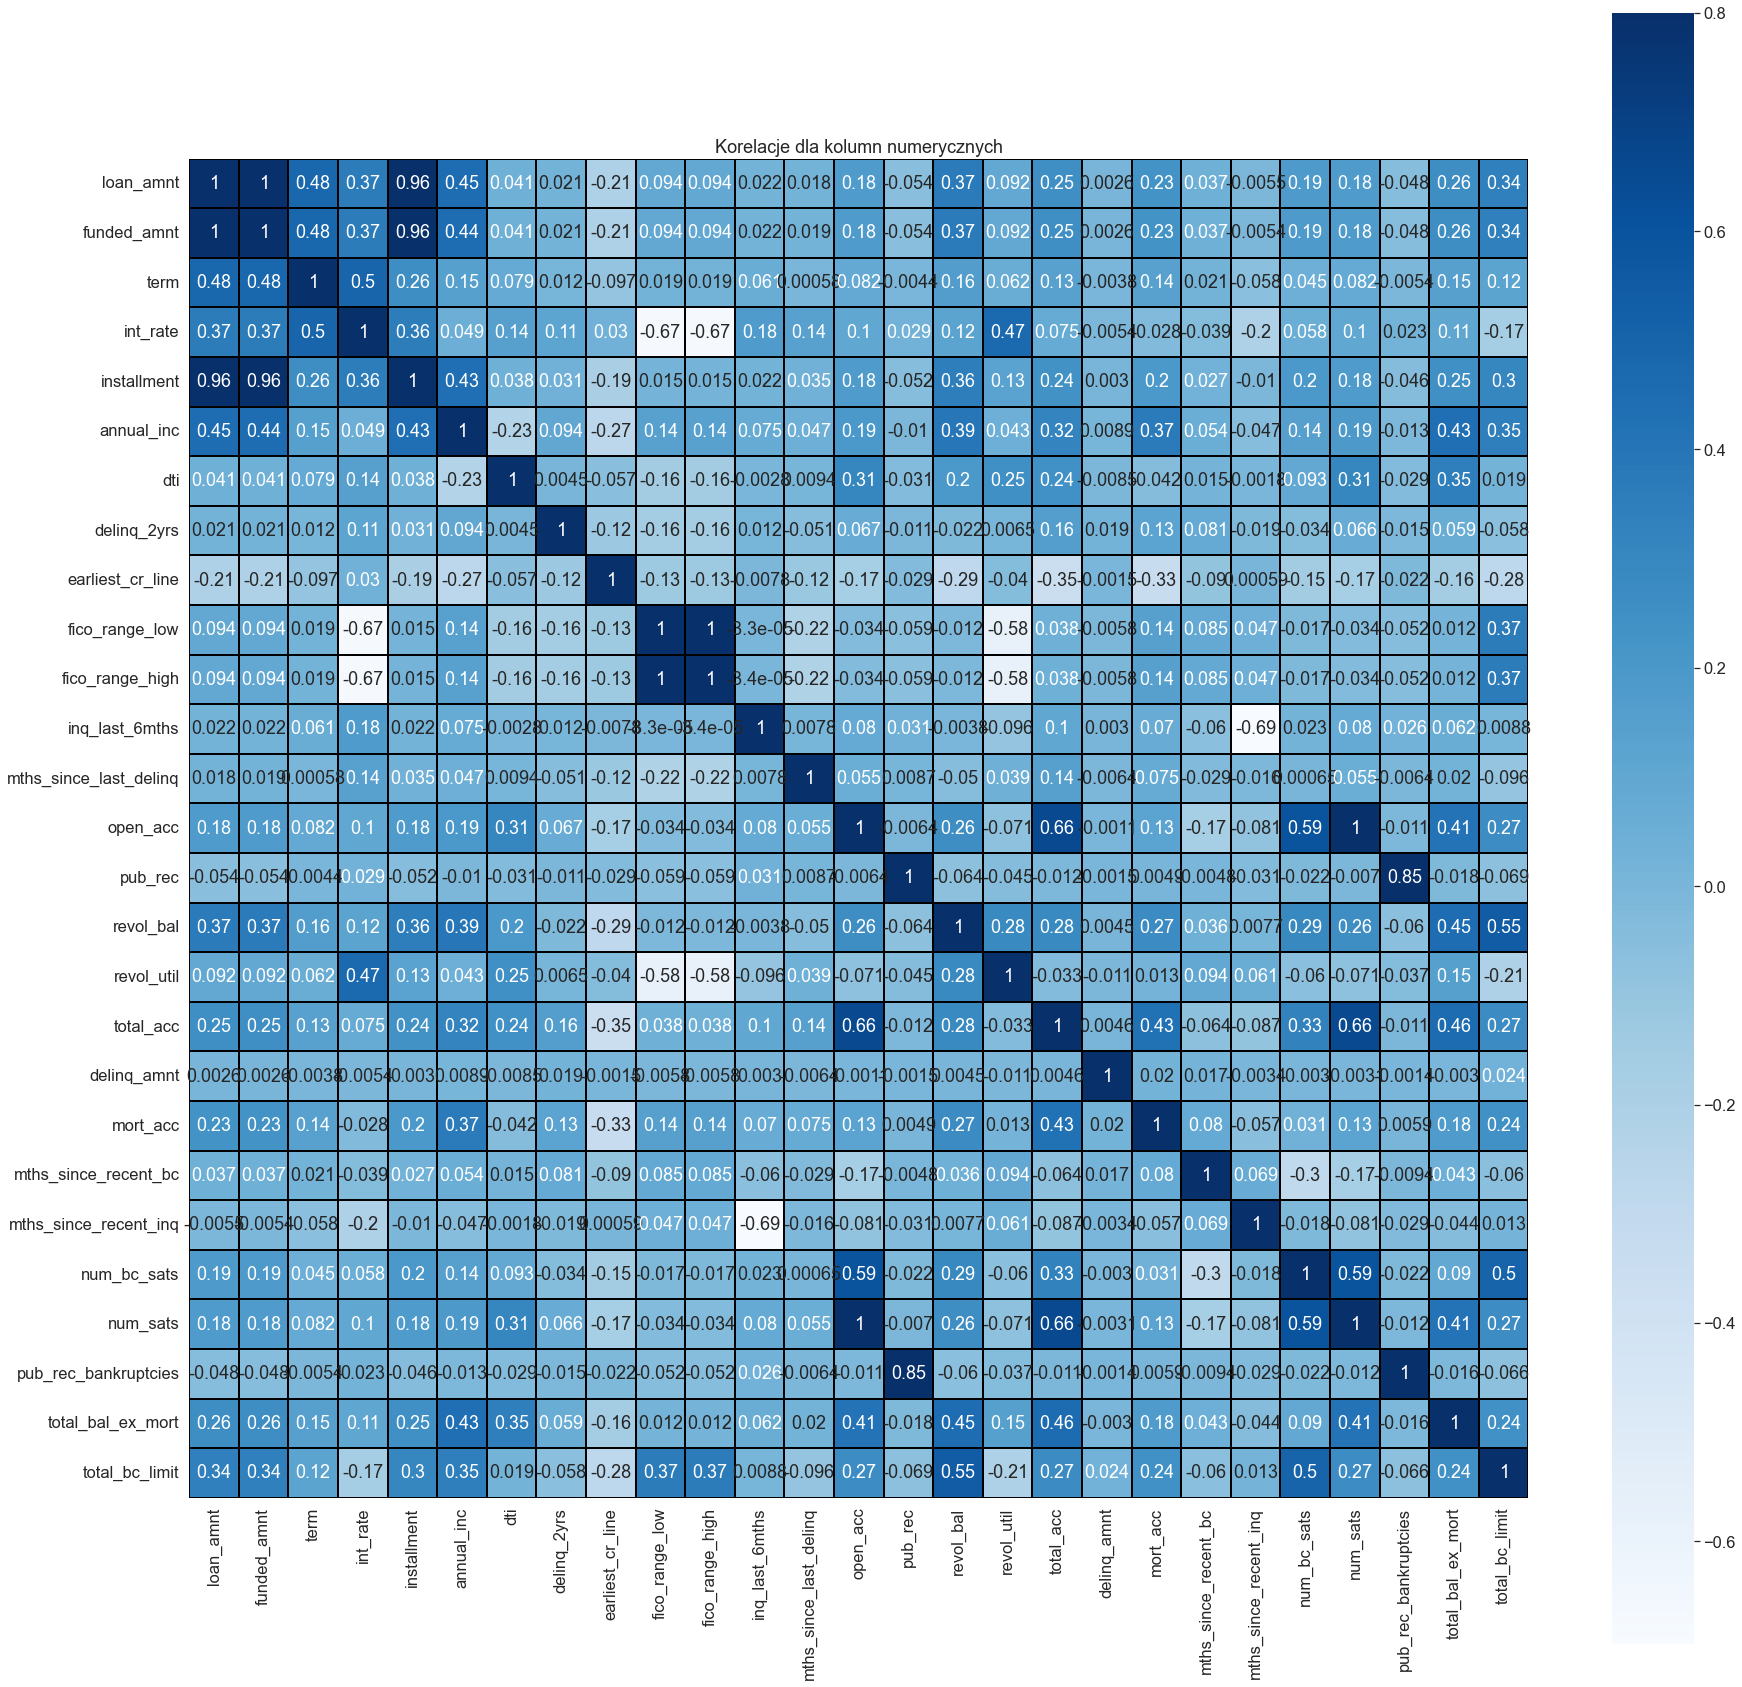

In [36]:
sns.set(font_scale=1.5)
plt.figure(figsize=(30, 30))

sns.heatmap(df7_corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap="Blues",linecolor="black")
plt.title('Korelacje dla kolumn numerycznych');

In [37]:
df7['fico_range_low'] = df7['fico_range_low'].astype('int64')
df7['fico_range_high'] = df7['fico_range_high'].astype('int64')
df7.head(2)

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/3670428054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['fico_range_low'] = df7['fico_range_low'].astype('int64')
C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/3670428054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['fico_range_high'] = df7['fico_range_high'].astype('int64')


loan_amnt  funded_amnt  term  int_rate  installment grade emp_length  \
33257     2000.0       2000.0    36     17.27        71.58     C    2 years   
33258     7750.0       7750.0    36     13.11       261.54     B  10+ years   

      home_ownership  annual_inc verification_status  ... total_acc  \
33257           RENT     26000.0        Not Verified  ...      13.0   
33258       MORTGAGE     39500.0            Verified  ...      38.0   

      delinq_amnt  mort_acc  mths_since_recent_bc  mths_since_recent_inq  \
33257         0.0       0.0                   5.0                    5.0   
33258         0.0       4.0                  68.0                    1.0   

       num_bc_sats  num_sats  pub_rec_bankruptcies  total_bal_ex_mort  \
33257          6.0      11.0                   0.0            36339.0   
33258          2.0      11.0                   0.0            82047.0   

       total_bc_limit  
33257          9100.0  
33258          7600.0  

[2 rows x 33 columns]

In [38]:
df7['fico_avg'] = df7[['fico_range_low', 'fico_range_high']].mean(axis=1)
df7['fico_avg'] = df7['fico_avg'].astype('int64')

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/2389162368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['fico_avg'] = df7[['fico_range_low', 'fico_range_high']].mean(axis=1)
C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/2389162368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['fico_avg'] = df7['fico_avg'].astype('int64')


In [39]:
#kopia zapasowa, aby mieć dostępną wersję zdekodowaną i oryginalną
df8 = df7.copy()

In [40]:
#aby sprawdzić korelacje, zdekodujemy kolumnę 'loan_status', by zawierała wartości liczbowe, 
#odpowiednio 0 oraz 1 dla Charged Off oraz Fully Paid

df8['loan_status'].replace(['Fully Paid','Charged Off'],[1,0], inplace=True)
df8['loan_status'].value_counts()

1    26037
0     5199
Name: loan_status, dtype: int64

In [41]:
#siatka korelacji wybranych zmiennych
df8[['earliest_cr_line', 'fico_avg', 'loan_status']].corr().round(2)

earliest_cr_line  fico_avg  loan_status
earliest_cr_line              1.00     -0.13        -0.02
fico_avg                     -0.13      1.00         0.12
loan_status                  -0.02      0.12         1.00

In [42]:
#sprawdzenie korelacji między wiekiem kredytowym, a fico 
ad2_corr = df7['earliest_cr_line'].corr(df7['fico_avg'])
ad2_corr.round(2)

-0.13

In [43]:
#zamiana statusów na wartości liczbowe
df8['home_ownership'].replace(['RENT','MORTGAGE','OWN','OTHER','NONE'],[1,2,3,4,5], inplace=True)

In [44]:
#słownik dla zapisania parametrów i ich nowych wartości
df8_home = {'RENT':1, 'MORTGAGE':2, 'OWN':3, 'OTHER':4, 'NONE':5}
df8_home

{'RENT': 1, 'MORTGAGE': 2, 'OWN': 3, 'OTHER': 4, 'NONE': 5}

In [45]:
#sprawdzenie korelacji
ad3_corr = df8['home_ownership'].corr(df8['loan_status'])
ad3_corr.round(2)

0.03

In [46]:
df7.annual_inc.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).round(2)

count     31236.00
mean      69239.84
std       35769.48
min        5000.00
10%       34000.00
25%       45000.00
50%       60000.00
75%       85000.00
90%      115000.00
max      270000.00
Name: annual_inc, dtype: float64

In [47]:
#dodanie kolumny z przedziałami
df8_ainc_conditions = [
    np.logical_and(df['annual_inc'].gt(0), np.less_equal(df['annual_inc'], 4999)),
    np.logical_and(df['annual_inc'].gt(5000), np.less_equal(df['annual_inc'],9999)),
    np.logical_and(df['annual_inc'].gt(10000), np.less_equal(df['annual_inc'],19999)),
    np.logical_and(df['annual_inc'].gt(20000), np.less_equal(df['annual_inc'],29999)),
    np.logical_and(df['annual_inc'].gt(30000), np.less_equal(df['annual_inc'],39999)),
    np.logical_and(df['annual_inc'].gt(40000), np.less_equal(df['annual_inc'],49999)),
    np.logical_and(df['annual_inc'].gt(50000), np.less_equal(df['annual_inc'],59999)),
    np.logical_and(df['annual_inc'].gt(60000), np.less_equal(df['annual_inc'],69999)),
    np.logical_and(df['annual_inc'].gt(70000), np.less_equal(df['annual_inc'],79999)),
    np.logical_and(df['annual_inc'].gt(80000), np.less_equal(df['annual_inc'],89999)),
    np.logical_and(df['annual_inc'].gt(90000), np.less_equal(df['annual_inc'],99999)),
    np.logical_and(df['annual_inc'].gt(100000), np.less_equal(df['annual_inc'],199999)),
]

df7_ainc_outputs = ['>5k', '>10k', '>20k', '>30k', '>40k', '>50k', '>60k', '>70k', '>80k', '>90k', '>100k',  '>200k']
df8_ainc_outputs =['5000', '10000', '20000', '30000', '40000', '50000', '60000', '70000', '80000', '90000', '100000',  '200000']
df8_ainc_counts = ['>5k', '>10k', '>20k', '>30k', '>40k', '>50k', '>60k', '>70k', '>80k', '>90k', '>100k',  '>200k', '+200k']

df7['annual_inc_range'] = pd.Series(np.select(df8_ainc_conditions, df7_ainc_outputs, '+200k'))
df8['annual_inc_range'] = pd.Series(np.select(df8_ainc_conditions, df8_ainc_outputs, '200000')).astype('int64')

df7.head(8)

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/3577190490.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['annual_inc_range'] = pd.Series(np.select(df8_ainc_conditions, df7_ainc_outputs, '+200k'))


loan_amnt  funded_amnt  term  int_rate  installment grade emp_length  \
33257     2000.0       2000.0    36     17.27        71.58     C    2 years   
33258     7750.0       7750.0    36     13.11       261.54     B  10+ years   
33260    20850.0      20850.0    60     17.77       526.85     D    6 years   
33261    12000.0      12000.0    36     14.33       412.06     C    6 years   
33262    10000.0      10000.0    36     19.72       370.22     D  10+ years   
33263     6000.0       6000.0    36     16.29       211.81     C  10+ years   
33264     8000.0       8000.0    36     18.49       291.19     D  10+ years   
33265    28000.0      28000.0    36      7.62       872.52     A  10+ years   

      home_ownership  annual_inc verification_status  ... mort_acc  \
33257           RENT     26000.0        Not Verified  ...      0.0   
33258       MORTGAGE     39500.0            Verified  ...      4.0   
33260       MORTGAGE    143784.0     Source Verified  ...      4.0   
33261            OWN     44000.0        Not Verified  ...      1.0   
33262           RENT     84000.0            Verified  ...      0.0   
33263           RENT     66500.0        Not Verified  ...      1.0   
33264       MORTGAGE     80000.0            Verified  ...      0.0   
33265           RENT     96200.0        Not Verified  ...      0.0   

      mths_since_recent_bc  mths_since_recent_inq  num_bc_sats  num_sats  \
33257                  5.0                    5.0          6.0      11.0   
33258                 68.0                    1.0          2.0      11.0   
33260                  7.0                    7.0          4.0      27.0   
33261                  2.0                    2.0          4.0      18.0   
33262                 32.0                    6.0          2.0      11.0   
33263                 44.0                   13.0          1.0       5.0   
33264                  7.0                    4.0          2.0       6.0   
33265                 20.0                    7.0          2.0       7.0   

       pub_rec_bankruptcies  total_bal_ex_mort  total_bc_limit  fico_avg  \
33257                   0.0            36339.0          9100.0       677   
33258                   0.0            82047.0          7600.0       712   
33260                   0.0           197634.0         12900.0       667   
33261                   0.0            52770.0         22000.0       712   
33262                   1.0            53546.0          3000.0       662   
33263                   1.0            19031.0          4000.0       677   
33264                   0.0            44856.0          3000.0       687   
33265                   0.0            36455.0         42000.0       787   

       annual_inc_range  
33257              >30k  
33258              >40k  
33260             >200k  
33261              >50k  
33262              >90k  
33263              >70k  
33264             +200k  
33265             >100k  

[8 rows x 35 columns]

In [48]:
#przegląd danych w kolumnie 'emp_length'
df7['emp_length'].value_counts()

10+ years    9684
2 years      2939
5 years      2764
< 1 year     2367
4 years      2300
3 years      2290
6 years      2239
1 year       2178
7 years      1900
8 years      1418
9 years      1157
Name: emp_length, dtype: int64

In [49]:
#zamiana wartości
df8_emp_length = {'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6,
                  '7 years':7, '8 years':8, '9 years':9, '10+ years':10}

df8['emp_length'] = df8['emp_length'].replace(df8_emp_length)

In [50]:
#rozkład procentowy pożyczek z pespektywy stażu pracy
df_emp = df8.groupby('emp_length')['loan_status'].value_counts(normalize=True)
df_emp = df_emp.mul(100)
df_emp = df_emp.rename('percent').reset_index()
df_emp.round(2).sort_values('emp_length').reset_index()

index  emp_length  loan_status  percent
0       0           0            1    83.40
1       1           0            0    16.60
2       2           1            1    84.34
3       3           1            0    15.66
4       4           2            1    84.04
5       5           2            0    15.96
6       6           3            1    83.19
7       7           3            0    16.81
8       8           4            1    82.96
9       9           4            0    17.04
10     11           5            0    16.50
11     10           5            1    83.50
12     12           6            1    82.58
13     13           6            0    17.42
14     14           7            1    81.84
15     15           7            0    18.16
16     16           8            1    82.86
17     17           8            0    17.14
18     18           9            1    82.97
19     19           9            0    17.03
20     20          10            1    83.60
21     21          10            0    16.40

In [51]:
#sprawdzenie korelacji
ad2_corr = df8['funded_amnt'].corr(df8['loan_status'])
ad2_corr.round(2)

-0.07

In [52]:
df8.dtypes

loan_amnt                 float64
funded_amnt               float64
term                        int64
int_rate                  float64
installment               float64
grade                      object
emp_length                  int64
home_ownership              int64
annual_inc                float64
verification_status        object
loan_status                 int64
purpose                    object
dti                       float64
delinq_2yrs               float64
earliest_cr_line            int64
fico_range_low              int64
fico_range_high             int64
inq_last_6mths            float64
mths_since_last_delinq    float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_acc                 float64
delinq_amnt               float64
mort_acc                  float64
mths_since_recent_bc      float64
mths_since_recent_inq     float64
num_bc_sats               float64
num_sats      

In [53]:
#df8.select_dtypes(include=['object'])

In [54]:
#tworzenie nowych kolumny z kolumny 'purpose'
df8 = pd.concat([df8, pd.get_dummies(df8['purpose'], dtype=('int64'))], axis=1)

In [55]:
#kolumna z procentem otrzymanej pożyczki wobec wnioskowanej kwoty
df8['success_score'] = (df8['funded_amnt'] / (df8['loan_amnt']) * 100)

In [56]:
#kolumna ukazjuąca jak duża jest pożyczka względem rocznych zarobków
df8['help_score'] = (df8['funded_amnt'] / (df8['annual_inc']) * 100).round(2)

In [57]:
#jakim procentem jest rata wobec miesięcznego dochodu (roczny przez 12 podzielony)
df7['insta_share'] = ((df7['installment'] / (df7['annual_inc']/12)) * 100).round(2)
df7.head(2)

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/1527669031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['insta_share'] = ((df7['installment'] / (df7['annual_inc']/12)) * 100).round(2)


loan_amnt  funded_amnt  term  int_rate  installment grade emp_length  \
33257     2000.0       2000.0    36     17.27        71.58     C    2 years   
33258     7750.0       7750.0    36     13.11       261.54     B  10+ years   

      home_ownership  annual_inc verification_status  ...  \
33257           RENT     26000.0        Not Verified  ...   
33258       MORTGAGE     39500.0            Verified  ...   

      mths_since_recent_bc mths_since_recent_inq  num_bc_sats  num_sats  \
33257                  5.0                   5.0          6.0      11.0   
33258                 68.0                   1.0          2.0      11.0   

       pub_rec_bankruptcies  total_bal_ex_mort  total_bc_limit  fico_avg  \
33257                   0.0            36339.0          9100.0       677   
33258                   0.0            82047.0          7600.0       712   

       annual_inc_range  insta_share  
33257              >30k         3.30  
33258              >40k         7.95  

[2 rows x 36 columns]

In [58]:
#dodanie tej samej kolumny do df8
df8['insta_share'] = ((df8['installment'] / (df8['annual_inc']/12)) * 100).round(2)

In [59]:
#kolumny 'grade' oraz 'verification_status' zamienimy na wartości liczbowe
df8['grade'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G'],[1,2,3,4,5,6,7], inplace=True)

In [60]:
#słownik z nowymi wartościami
df8_grade = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
df8_grade

{'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

In [61]:
df8['verification_status'].replace(['Not Verified','Verified','Source Verified'],[0,1,2], inplace=True)

#słownik
df8_ver_stat = {'Not Verified':0,'Verified':1,'Source Verified':2}
df8_ver_stat

{'Not Verified': 0, 'Verified': 1, 'Source Verified': 2}

In [62]:
df8.shape

(31236, 51)

In [63]:
#usuwamy kolumny, które się nie przydadzą i które zostały już zdekodowane do innych kolumn
df8 = df8.drop(['purpose'], axis=1)

In [64]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31236 entries, 33257 to 70696
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               31236 non-null  float64
 1   funded_amnt             31236 non-null  float64
 2   term                    31236 non-null  int64  
 3   int_rate                31236 non-null  float64
 4   installment             31236 non-null  float64
 5   grade                   31236 non-null  int64  
 6   emp_length              31236 non-null  int64  
 7   home_ownership          31236 non-null  int64  
 8   annual_inc              31236 non-null  float64
 9   verification_status     31236 non-null  int64  
 10  loan_status             31236 non-null  int64  
 11  dti                     31236 non-null  float64
 12  delinq_2yrs             31236 non-null  float64
 13  earliest_cr_line        31236 non-null  int64  
 14  fico_range_low          31236 non-

In [65]:
#tworzenie kopi źródła danych pod modelowanie
X = df8.copy()

In [66]:
X.shape

(31236, 50)

### Standaryzacja danych

In [67]:
#wykonanie standaryzacji
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [68]:
X_scaled[:5,:5]

array([[-1.44946343, -1.45001133, -0.48473312,  0.70156434, -1.46436163],
       [-0.73019267, -0.73001373, -0.48473312, -0.26211572, -0.68522465],
       [ 0.90849378,  0.91032862,  2.06299087,  0.81739127,  0.40296671],
       [-0.19855775, -0.1978416 , -0.48473312,  0.02050199, -0.06785417],
       [-0.44873889, -0.44827554, -0.48473312,  1.26911629, -0.23946446]])

In [69]:
X_columns = X.columns
X_columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'delinq_amnt', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq', 'num_bc_sats',
       'num_sats', 'pub_rec_bankruptcies', 'total_bal_ex_mort',
       'total_bc_limit', 'fico_avg', 'annual_inc_range', 'car', 'credit_card',
       'debt_consolidation', 'home_improvement', 'house', 'major_purchase',
       'medical', 'moving', 'other', 'renewable_energy', 'small_business',
       'vacation', 'wedding', 'success_score', 'help_score', 'insta_share'],
      dtype='object')

In [70]:
X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)

In [71]:
X_scaled_df.head(3)

loan_amnt  funded_amnt      term  int_rate  installment     grade  \
0  -1.449463    -1.450011 -0.484733  0.701564    -1.464362  0.220326   
1  -0.730193    -0.730014 -0.484733 -0.262116    -0.685225 -0.559251   
2   0.908494     0.910329  2.062991  0.817391     0.402967  0.999903   

   emp_length  home_ownership  annual_inc  verification_status  ...   medical  \
0   -1.092228       -1.050166   -1.208866            -1.059717  ... -0.105059   
1    1.167072        0.547875   -0.831444             0.302701  ... -0.105059   
2    0.037422        0.547875    2.084049             1.665120  ... -0.105059   

     moving     other  renewable_energy  small_business  vacation   wedding  \
0 -0.082468 -0.232048         -0.033968       -0.142773 -0.077606 -0.112735   
1 -0.082468 -0.232048         -0.033968       -0.142773 -0.077606 -0.112735   
2 -0.082468 -0.232048         -0.033968       -0.142773 -0.077606 -0.112735   

   success_score  help_score  insta_share  
0       0.030477   -1.255175    -1.182952  
1       0.030477   -0.159043    -0.052193  
2       0.030477   -0.629471    -0.915461  

[3 rows x 50 columns]

<AxesSubplot:>

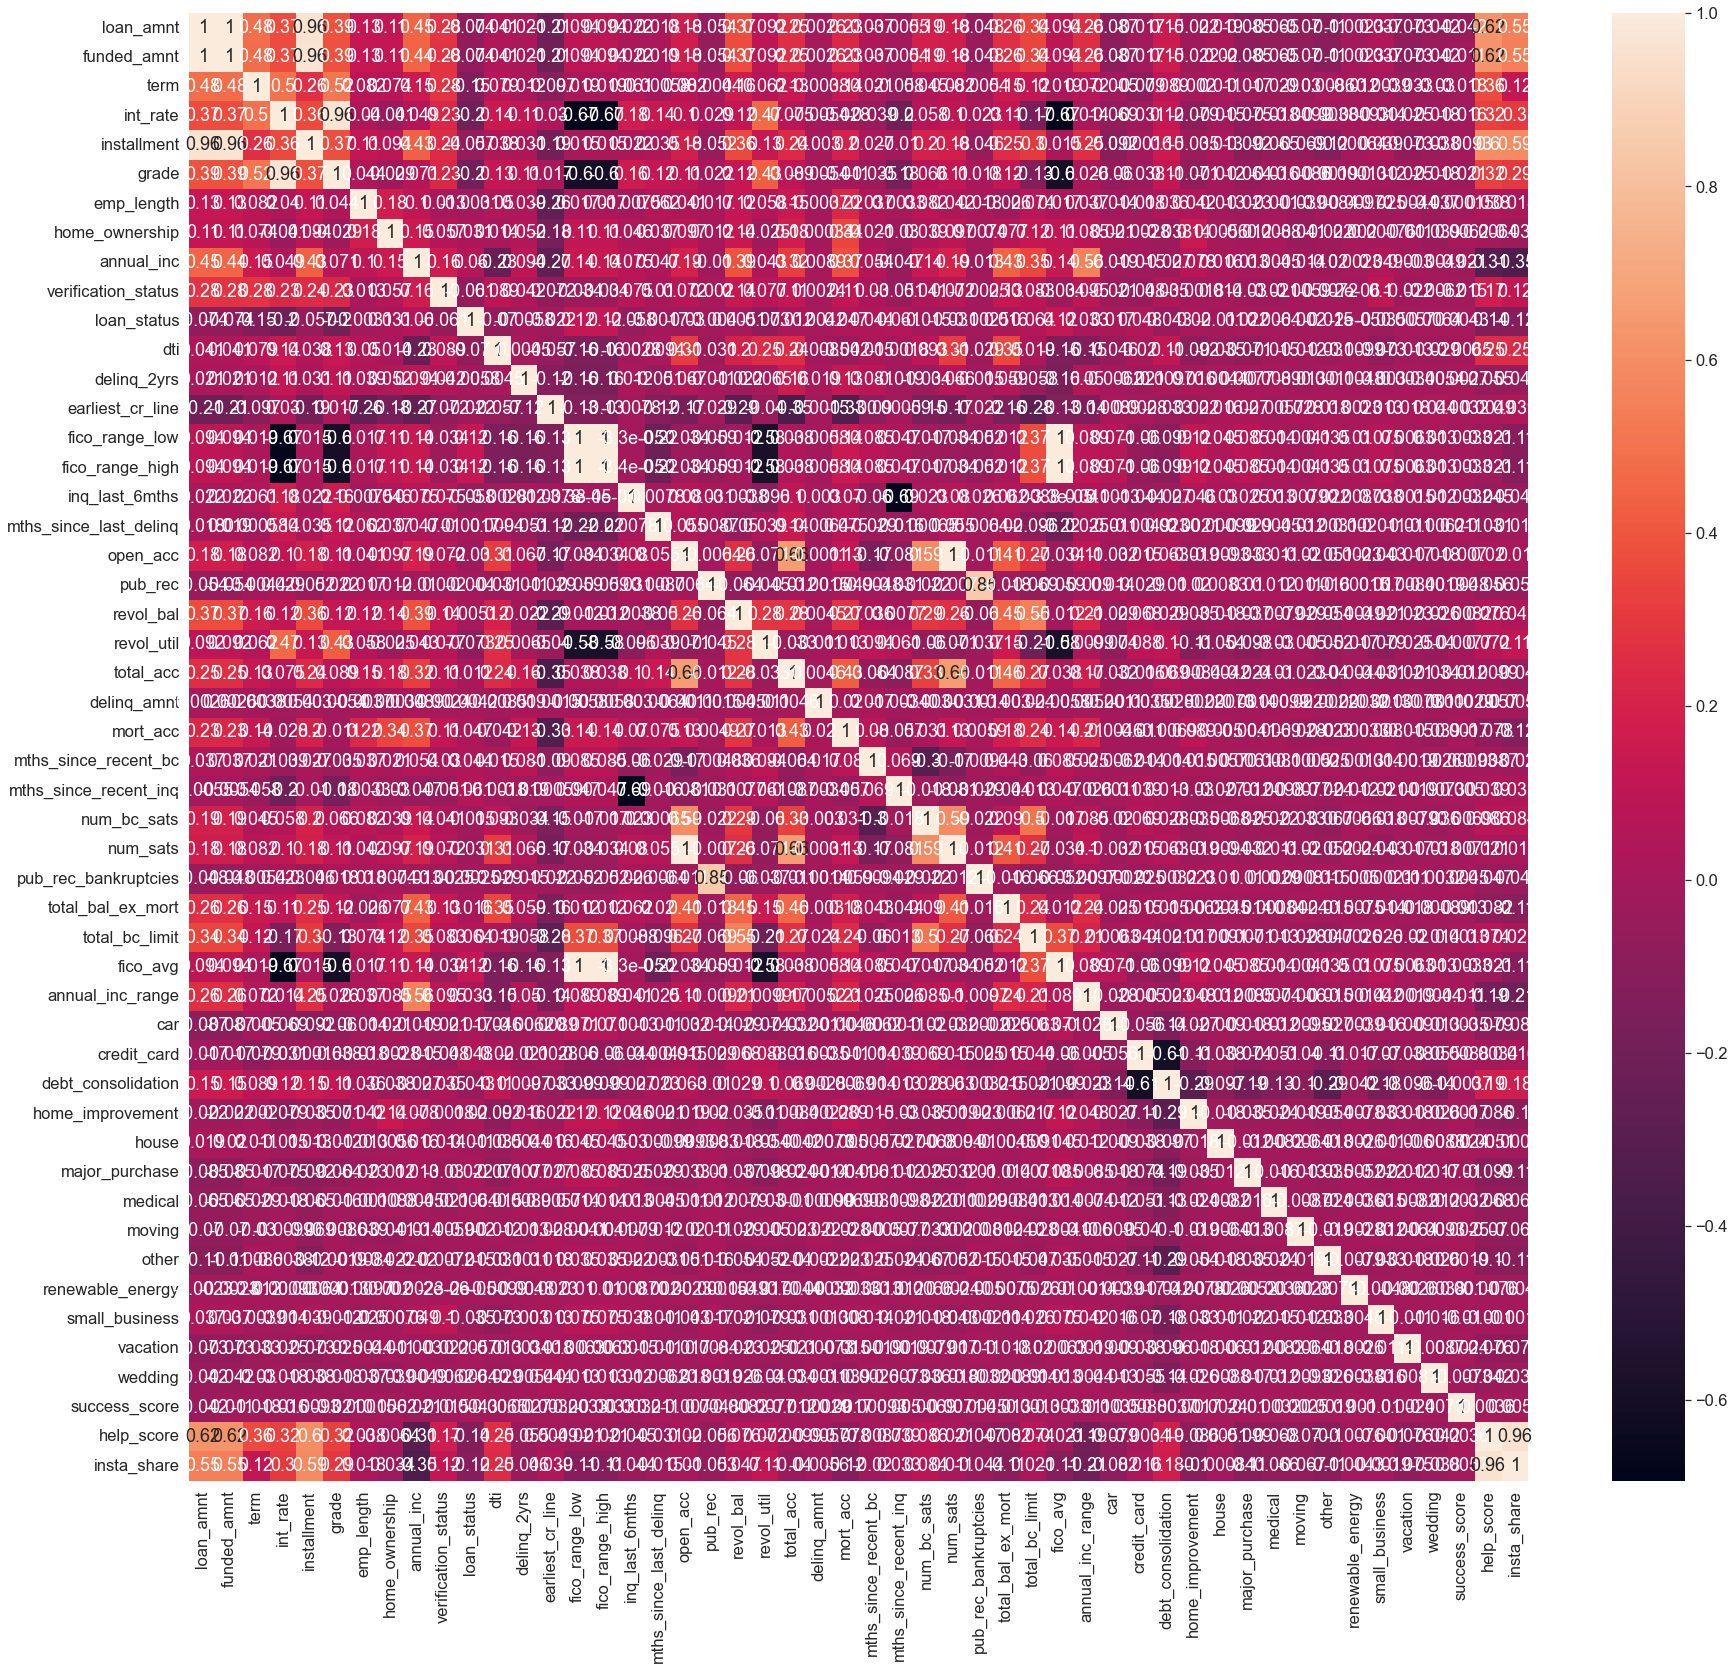

In [72]:
plt.figure(figsize = (30,27))       
sns.heatmap(X_scaled_df.corr(),annot = True)

In [73]:
X_scaled_df_cor = X_scaled_df.corr()
X_scaled_df_cor.round(2)

loan_amnt  funded_amnt  term  int_rate  installment  \
loan_amnt                    1.00         1.00  0.48      0.37         0.96   
funded_amnt                  1.00         1.00  0.48      0.37         0.96   
term                         0.48         0.48  1.00      0.50         0.26   
int_rate                     0.37         0.37  0.50      1.00         0.36   
installment                  0.96         0.96  0.26      0.36         1.00   
grade                        0.39         0.39  0.52      0.96         0.37   
emp_length                   0.13         0.13  0.08      0.04         0.11   
home_ownership               0.11         0.11  0.07     -0.04         0.09   
annual_inc                   0.45         0.44  0.15      0.05         0.43   
verification_status          0.28         0.28  0.28      0.23         0.24   
loan_status                 -0.07        -0.07 -0.15     -0.20        -0.06   
dti                          0.04         0.04  0.08      0.14         0.04   
delinq_2yrs                  0.02         0.02  0.01      0.11         0.03   
earliest_cr_line            -0.21        -0.21 -0.10      0.03        -0.19   
fico_range_low               0.09         0.09  0.02     -0.67         0.01   
fico_range_high              0.09         0.09  0.02     -0.67         0.01   
inq_last_6mths               0.02         0.02  0.06      0.18         0.02   
mths_since_last_delinq       0.02         0.02  0.00      0.14         0.04   
open_acc                     0.18         0.18  0.08      0.10         0.18   
pub_rec                     -0.05        -0.05 -0.00      0.03        -0.05   
revol_bal                    0.37         0.37  0.16      0.12         0.36   
revol_util                   0.09         0.09  0.06      0.47         0.13   
total_acc                    0.25         0.25  0.13      0.07         0.24   
delinq_amnt                  0.00         0.00 -0.00     -0.01         0.00   
mort_acc                     0.23         0.23  0.14     -0.03         0.20   
mths_since_recent_bc         0.04         0.04  0.02     -0.04         0.03   
mths_since_recent_inq       -0.01        -0.01 -0.06     -0.20        -0.01   
num_bc_sats                  0.19         0.19  0.05      0.06         0.20   
num_sats                     0.18         0.18  0.08      0.10         0.18   
pub_rec_bankruptcies        -0.05        -0.05 -0.01      0.02        -0.05   
total_bal_ex_mort            0.26         0.26  0.15      0.11         0.25   
total_bc_limit               0.34         0.34  0.12     -0.17         0.30   
fico_avg                     0.09         0.09  0.02     -0.67         0.01   
annual_inc_range             0.26         0.26  0.07      0.01         0.25   
car                         -0.09        -0.09 -0.01     -0.07        -0.09   
credit_card                 -0.02        -0.02 -0.08     -0.03         0.00   
debt_consolidation           0.15         0.15  0.09      0.12         0.15   
home_improvement            -0.02        -0.02  0.00     -0.08        -0.04   
house                        0.02         0.02  0.01     -0.02         0.01   
major_purchase              -0.09        -0.09 -0.02     -0.07        -0.09   
medical                     -0.07        -0.07 -0.03     -0.02        -0.07   
moving                      -0.07        -0.07 -0.03     -0.01        -0.07   
other                       -0.11        -0.11  0.01     -0.00        -0.12   
renewable_energy            -0.00        -0.00 -0.01     -0.00         0.00   
small_business               0.04         0.04 -0.00     -0.01         0.04   
vacation                    -0.07        -0.07 -0.03     -0.02        -0.07   
wedding                     -0.04        -0.04 -0.03     -0.02        -0.04   
success_score               -0.04        -0.01 -0.02     -0.02        -0.01   
help_score                   0.62         0.62  0.36      0.32         0.60   
insta_share                  0.55         0.55  0.12      0.30         0.5

In [74]:
#usuwamy kolumny o dużej korelacji ze źródła i ponownie robimy standaryzację
X2 = df8.copy()

In [75]:
X2.shape

(31236, 50)

In [76]:
X2 = X2.drop(['fico_range_low', 'fico_range_high', 'funded_amnt', 'installment', 'grade', 'total_bc_limit', 'help_score'], axis=1)
X2.shape

(31236, 43)

In [77]:
#ponowna standaryzacja, tym razem tylko kolumn bez wysokiej korelacji
X2_scaled = scaler.fit_transform(X2)

In [78]:
X2_scaled[:5,:5]

array([[-1.44946343, -0.48473312,  0.70156434, -1.09222818, -1.05016551],
       [-0.73019267, -0.48473312, -0.26211572,  1.16707164,  0.54787462],
       [ 0.90849378,  2.06299087,  0.81739127,  0.03742173,  0.54787462],
       [-0.19855775, -0.48473312,  0.02050199,  0.03742173,  2.14591475],
       [-0.44873889, -0.48473312,  1.26911629,  1.16707164, -1.05016551]])

In [79]:
X2_columns = X.columns
X2_columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'delinq_amnt', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq', 'num_bc_sats',
       'num_sats', 'pub_rec_bankruptcies', 'total_bal_ex_mort',
       'total_bc_limit', 'fico_avg', 'annual_inc_range', 'car', 'credit_card',
       'debt_consolidation', 'home_improvement', 'house', 'major_purchase',
       'medical', 'moving', 'other', 'renewable_energy', 'small_business',
       'vacation', 'wedding', 'success_score', 'help_score', 'insta_share'],
      dtype='object')

In [80]:
X2_scaled_df = pd.DataFrame(X2_scaled,columns=X2.columns)

In [81]:
X2_scaled_df.head(2)

loan_amnt      term  int_rate  emp_length  home_ownership  annual_inc  \
0  -1.449463 -0.484733  0.701564   -1.092228       -1.050166   -1.208866   
1  -0.730193 -0.484733 -0.262116    1.167072        0.547875   -0.831444   

   verification_status  loan_status       dti  delinq_2yrs  ...  \
0            -1.059717     0.446853  1.014270    -0.342843  ...   
1             0.302701     0.446853  2.121949     1.101982  ...   

   major_purchase   medical    moving     other  renewable_energy  \
0       -0.152838 -0.105059 -0.082468 -0.232048         -0.033968   
1       -0.152838 -0.105059 -0.082468 -0.232048         -0.033968   

   small_business  vacation   wedding  success_score  insta_share  
0       -0.142773 -0.077606 -0.112735       0.030477    -1.182952  
1       -0.142773 -0.077606 -0.112735       0.030477    -0.052193  

[2 rows x 43 columns]

<AxesSubplot:>

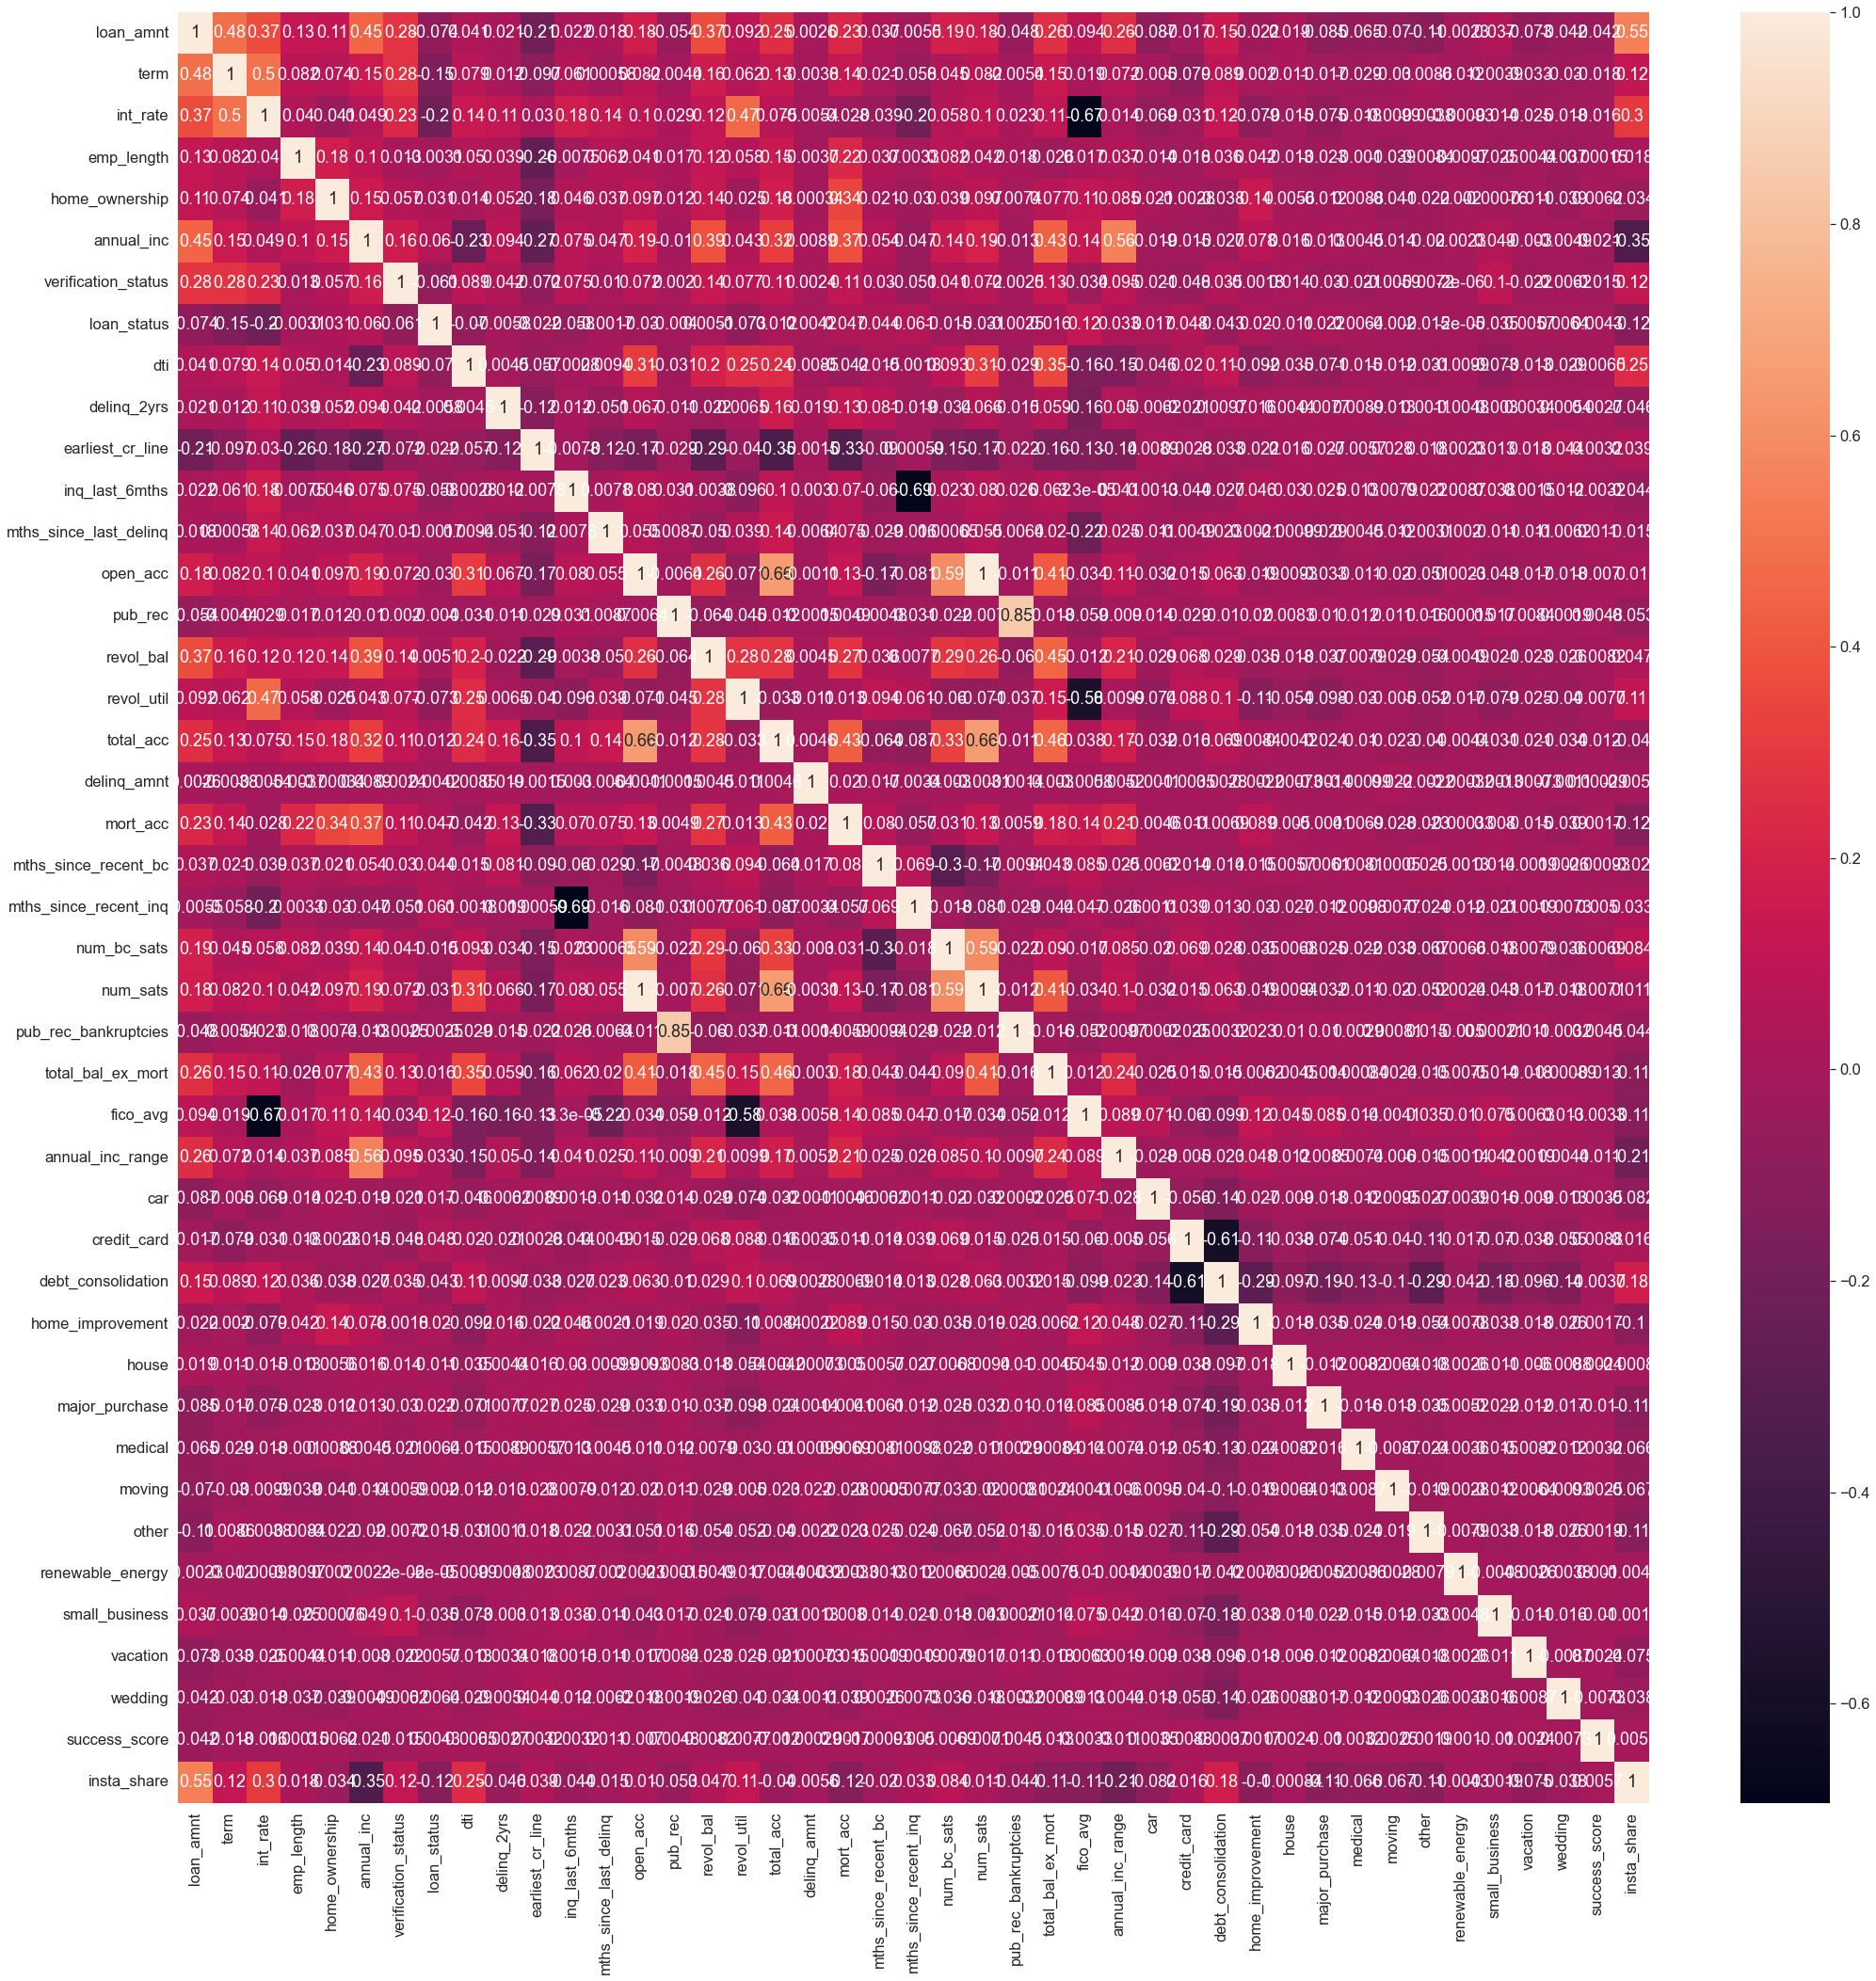

In [82]:
#ponowne sprawdzenie siatki korelacji, w celu zweryfikowania czy występują kolumny z korelacją >0.9
plt.figure(figsize = (35,35))       
sns.heatmap(X2_scaled_df.corr(),annot = True)

## Modelowanie

In [83]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### Regresja Logistyczna

In [84]:
#przygotowujemy źródło danych

In [85]:
x = X2.copy()

In [86]:
x.head()

loan_amnt  term  int_rate  emp_length  home_ownership  annual_inc  \
33257     2000.0    36     17.27           2               1     26000.0   
33258     7750.0    36     13.11          10               2     39500.0   
33260    20850.0    60     17.77           6               2    143784.0   
33261    12000.0    36     14.33           6               3     44000.0   
33262    10000.0    36     19.72          10               1     84000.0   

       verification_status  loan_status    dti  delinq_2yrs  ...  \
33257                    0            1  25.62          0.0  ...   
33258                    1            1  34.24          1.0  ...   
33260                    2            1  24.20          0.0  ...   
33261                    0            1  25.01          2.0  ...   
33262                    1            1  19.63          0.0  ...   

       major_purchase  medical  moving  other  renewable_energy  \
33257               0        0       0      0                 0   
33258               0        0       0      0                 0   
33260               0        0       0      0                 0   
33261               0        0       0      0                 0   
33262               0        0       0      0                 0   

       small_business  vacation  wedding  success_score  insta_share  
33257               0         0        0          100.0         3.30  
33258               0         0        0          100.0         7.95  
33260               0         0        0          100.0         4.40  
33261               0         0        0          100.0        11.24  
33262               0         0        1          100.0         5.29  

[5 rows x 43 columns]

In [87]:
# Dzielenie danych na etykiety i atrybuty
y = x.loan_status.values
x_data = x.drop(['loan_status'], axis = 1)

In [88]:
# Skalowanie danych 
x = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data)).values

In [89]:
# Split danych na zbiór treningowy i testowy
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=42)

x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

print("x_train: ",x_train.shape)
print("x_test: ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

x_train:  (42, 24988)
x_test:  (42, 6248)
y_train:  (24988,)
y_test:  (6248,)


In [90]:
# dimension = 30
def initialize_weights_and_bias(dimension):
    
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w,b

In [91]:
def sigmoid(z):
    
    y_head = 1/(1+ np.exp(-z))
    return y_head

In [92]:
 def forward_backward_propagation(w,b,x_train,y_train):   
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]                 # x_train.shape[1]  is for scaling
    gradients = {"derivative_weight": derivative_weight, "derivative_bias": derivative_bias}
    
    return cost,gradients

In [93]:
def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    # updating(learning) parameters is number_of_iterarion times
    for i in range(number_of_iterarion):
        # make forward and backward propagation and find cost and gradients
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        # lets update
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 10 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
            
    # we update(learn) parameters weights and bias
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

In [94]:
def predict(w,b,x_test):
    # x_test is a input for forward propagation
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

Cost after iteration 0: 0.665086
Cost after iteration 10: 0.438956
Cost after iteration 20: 0.431361
Cost after iteration 30: 0.427995
Cost after iteration 40: 0.426092
Cost after iteration 50: 0.424824
Cost after iteration 60: 0.423899
Cost after iteration 70: 0.423190
Cost after iteration 80: 0.422629
Cost after iteration 90: 0.422177
Cost after iteration 100: 0.421805
Cost after iteration 110: 0.421495


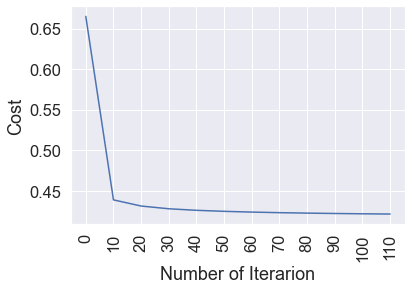

test accuracy: 83.2426376440461 %


In [95]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    # initialize
    dimension =  x_train.shape[0]  # that is 30
    w,b = initialize_weights_and_bias(dimension)
    # do not change learning rate
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)

    # Print test Errors
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 2, num_iterations = 120)  

In [96]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train.T,y_train.T)
print("test accuracy {}".format(lr.score(x_test.T,y_test.T)))

test accuracy 0.831786171574904


C:\Users\Kasia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [97]:
print("accuracy:", lr.score(x_test.T,y_test.T))
prediction = lr.predict(x_test.T)
model_lreg = metrics.roc_auc_score(y_test.T,prediction)
print("auroc:", model_lreg)

accuracy: 0.831786171574904
auroc: 0.505134264472287


#### Drzewo decyzyjne

In [98]:
from sklearn.tree import DecisionTreeClassifier

In [99]:
#przywrócenie źródła do momentu sprzed regresji
x = X2.copy()

In [100]:
# Dzielenie danych na etykiety i atrybuty
X = x.drop(['loan_status'], axis = 1)
y = x.loan_status.values

In [101]:
#poział na zbiór testowy i treningowy
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [102]:
dtree = DecisionTreeClassifier()

In [103]:
dtree.fit(x_train,y_train)

DecisionTreeClassifier()

In [104]:
def evaluate(prediction,y_test): 
    result = classification_report(y_test,prediction,output_dict=True)
    f1 = result['1']['f1-score']
    accuracy = result['accuracy']
    performance_data= {'f1-score':round(f1, 2),
                      'accuracy':round(accuracy, 2)}
    return performance_data

In [105]:
dt_prediction = dtree.predict(x_test)

In [106]:
from sklearn.metrics import classification_report,confusion_matrix, precision_score

In [107]:
print(classification_report(y_test,dt_prediction))

dtree_pr= evaluate(dt_prediction,y_test)
dtree_pr

              precision    recall  f1-score   support

           0       0.22      0.23      0.22      1570
           1       0.84      0.83      0.84      7801

    accuracy                           0.73      9371
   macro avg       0.53      0.53      0.53      9371
weighted avg       0.74      0.73      0.73      9371



{'f1-score': 0.84, 'accuracy': 0.73}

In [108]:
print("accuracy:", dtree.score(x_test,y_test))
prediction = dtree.predict(x_test)
model_dtree = metrics.roc_auc_score(y_test,dt_prediction)
print("auroc:", model_dtree)

accuracy: 0.7290577312986875
auroc: 0.531248933461903


[Text(735.1695156735099, 1072.5081081081082, 'X[2] <= 15.555\ngini = 0.277\nsamples = 21865\nvalue = [3629, 18236]'),
 Text(358.90913308142586, 1043.1243243243243, 'X[2] <= 12.615\ngini = 0.21\nsamples = 14039\nvalue = [1671, 12368]'),
 Text(142.3311491713118, 1013.7405405405406, 'X[2] <= 7.76\ngini = 0.164\nsamples = 7866\nvalue = [710, 7156]'),
 Text(53.56316780321816, 984.3567567567568, 'X[37] <= 0.5\ngini = 0.088\nsamples = 1595\nvalue = [74, 1521]'),
 Text(44.14164810618349, 954.972972972973, 'X[21] <= 8.5\ngini = 0.08\nsamples = 1540\nvalue = [64, 1476]'),
 Text(31.077020409385064, 925.5891891891893, 'X[9] <= 2002.5\ngini = 0.069\nsamples = 1434\nvalue = [51, 1383]'),
 Text(13.344519513384986, 896.2054054054055, 'X[3] <= 0.5\ngini = 0.053\nsamples = 1176\nvalue = [32, 1144]'),
 Text(2.8530907755275074, 866.8216216216217, 'X[16] <= 11.5\ngini = 0.146\nsamples = 88\nvalue = [7, 81]'),
 Text(1.1556823394541802, 837.4378378378378, 'X[7] <= 5.7\ngini = 0.444\nsamples = 6\nvalue = [2, 

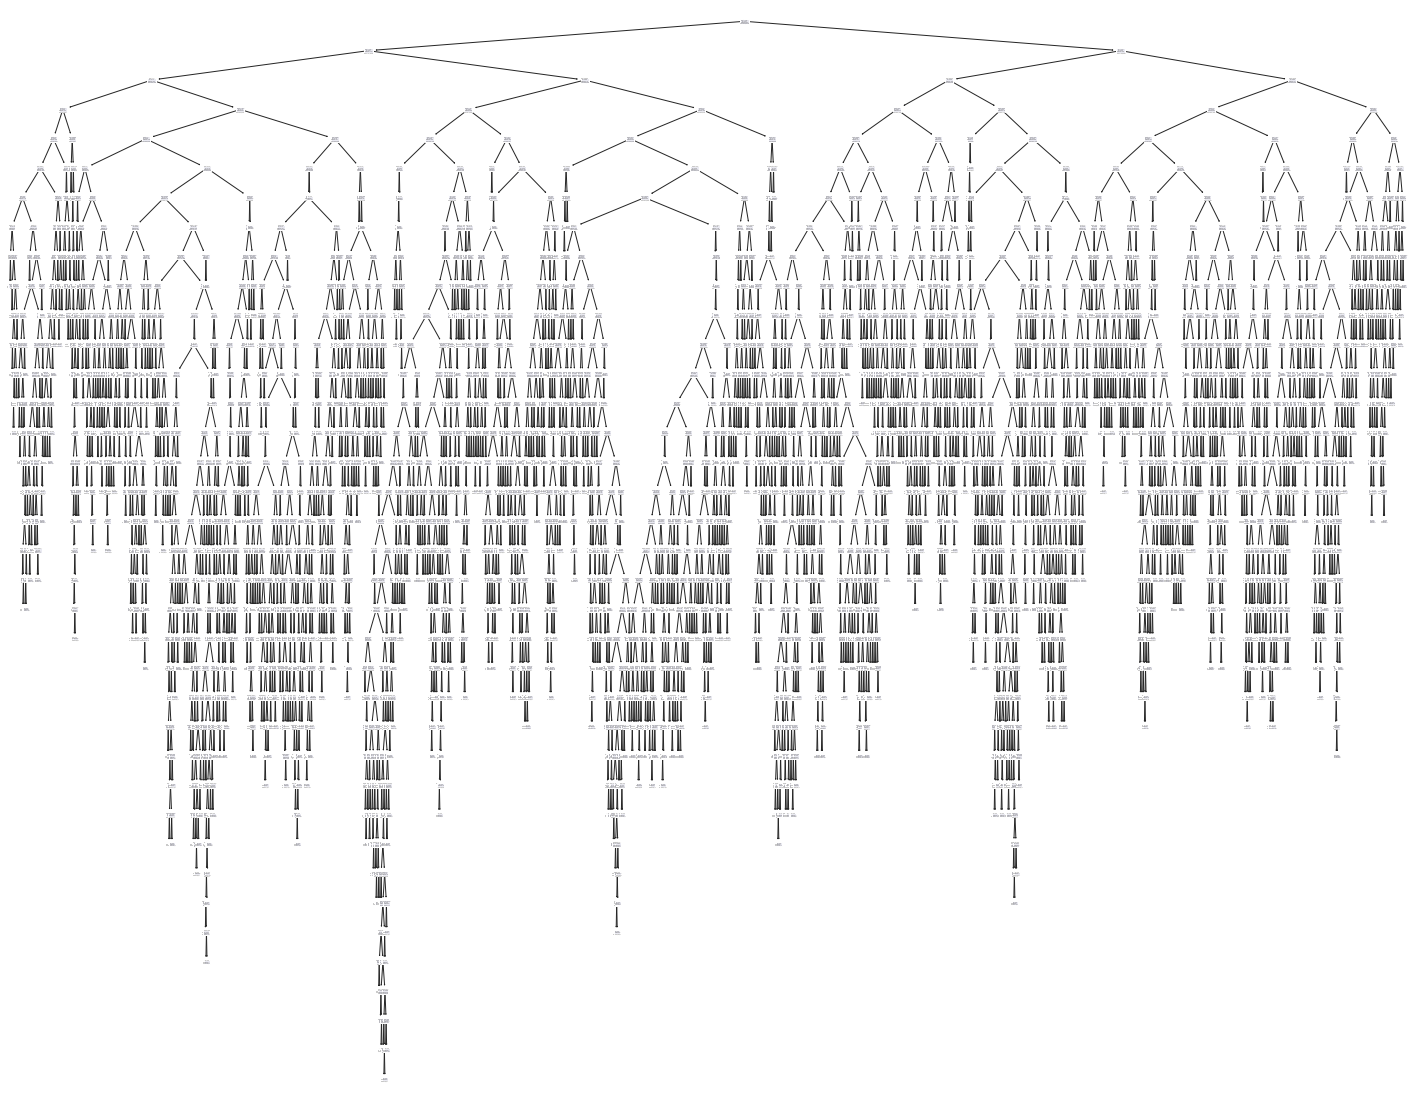

In [109]:
from sklearn import tree
plt.figure(figsize=(25,20))

tree.plot_tree(dtree)

#### Modele

In [110]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
model.fit(x_train, y_train)
print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_bagclass = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_bagclass)

accuracy: 0.8025824351723402
auroc: 0.5298764571257808


In [111]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(random_state=1)
model.fit(x_train, y_train)
print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_adaboost = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_adaboost)

accuracy: 0.830541030839825
auroc: 0.5039338415702054


In [112]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(x_train, y_train)
print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_gradboost = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_gradboost)

accuracy: 0.8324618503894995
auroc: 0.5


In [113]:
import xgboost as xgb 
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(x_train, y_train)
print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_xgboost = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_xgboost)

C:\Users\Kasia\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:57:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.8315014406146622
auroc: 0.5012037898129996


In [114]:
#podsumowanie modeli
prediction_data={'Model':['Regresja Logistyczna',
                          'Drzewo Decyzyjne',
                          'BaggingClassifier',
                          'AdaBoostClassifier',
                          'GradientBoostingClassifier',
                          'XGBoost '
                         ],
                                    
                   'AUROC':[model_lreg,
                              model_dtree,
                              model_bagclass,
                              model_adaboost,
                              model_gradboost,
                              model_xgboost]
                    }
 
#DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

Model     AUROC
0        Regresja Logistyczna  0.505134
1            Drzewo Decyzyjne  0.531249
2           BaggingClassifier  0.529876
3          AdaBoostClassifier  0.503934
4  GradientBoostingClassifier  0.500000
5                    XGBoost   0.501204

## SMOTE
#### dostosowanie zbioru treningowego, by był bardziej zbalansowany

In [115]:
#import bibliotek
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

#przywrócenie danych do momentu wyjściowego
X4_smote = X2.copy()

In [116]:
# Dzielenie danych na etykiety i atrybuty
x = X4_smote.drop(['loan_status'], axis = 1)
y = X4_smote.loan_status.values

In [117]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=100,test_size=0.3,stratify=y)

In [118]:
#porównanie liczby próbek przed i po zbalansowaniu zbioru

print("przed SMOTE, zmienna '1': {}".format(sum(y_train == 1))) 
print("przed SMOTE, zmienna '0': {} \n".format(sum(y_train == 0))) 
  
from imblearn.over_sampling import SMOTE 

sm = SMOTE(sampling_strategy=0.5,k_neighbors=5,random_state = 100) 
x_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel()) 
  
print('po SMOTE, zmienna  x_train: {}'.format(x_train_res.shape)) 
print('po SMOTE, zmienna  y_train: {} \n'.format(y_train_res.shape)) 
  
print("po SMOTE, zmienna '1': {}".format(sum(y_train_res == 1))) 
print("po SMOTE, zmienna '0': {}".format(sum(y_train_res == 0))) 

przed SMOTE, zmienna '1': 18226
przed SMOTE, zmienna '0': 3639 

po SMOTE, zmienna  x_train: (27339, 42)
po SMOTE, zmienna  y_train: (27339,) 

po SMOTE, zmienna '1': 18226
po SMOTE, zmienna '0': 9113


In [119]:
#podmiana danych treningowych na zbalansowane
x_train = x_train_res
y_train = y_train_res

#backup danych testowych
x_test_bk = x_test
y_test_bk = y_test

## Modelowanie po zbalansowaniu zbioru  (SMOTE)

In [120]:
#sprawdzenie ilości zmiennych
x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

print("x_train: ",x_train.shape)
print("x_test: ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

x_train:  (42, 27339)
x_test:  (42, 9371)
y_train:  (27339,)
y_test:  (9371,)


In [121]:
# dimension = 30
def initialize_weights_and_bias(dimension):
    
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w,b

In [122]:
def sigmoid(z):
    
    y_head = 1/(1+ np.exp(-z))
    return y_head

In [123]:
 def forward_backward_propagation(w,b,x_train,y_train):   
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]                 # x_train.shape[1]  is for scaling
    gradients = {"derivative_weight": derivative_weight, "derivative_bias": derivative_bias}
    
    return cost,gradients

In [124]:
def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    # updating(learning) parameters is number_of_iterarion times
    for i in range(number_of_iterarion):
        # make forward and backward propagation and find cost and gradients
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        # lets update
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 10 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
            
    # we update(learn) parameters weights and bias
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

In [125]:
def predict(w,b,x_test):
    # x_test is a input for forward propagation
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

Cost after iteration 0: nan
Cost after iteration 10: nan
Cost after iteration 20: nan


C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/2931756544.py:5: RuntimeWarning: divide by zero encountered in log
  loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/2931756544.py:5: RuntimeWarning: invalid value encountered in multiply
  loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/466385090.py:3: RuntimeWarning: overflow encountered in exp
  y_head = 1/(1+ np.exp(-z))


Cost after iteration 30: nan
Cost after iteration 40: nan
Cost after iteration 50: nan
Cost after iteration 60: nan
Cost after iteration 70: nan
Cost after iteration 80: nan
Cost after iteration 90: nan
Cost after iteration 100: nan
Cost after iteration 110: nan


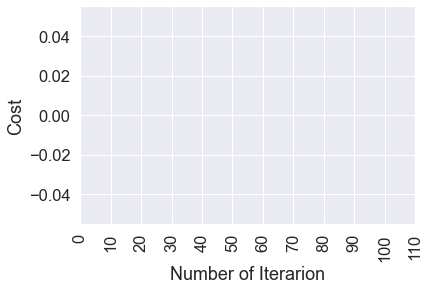

test accuracy: 16.924554476576674 %


In [126]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    # initialize
    dimension =  x_train.shape[0]  # that is 30
    w,b = initialize_weights_and_bias(dimension)
    # do not change learning rate
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)

    # Print test Errors
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 2, num_iterations = 120)  

In [127]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train.T,y_train.T)
print("test accuracy {}".format(lr.score(x_test.T,y_test.T)))

test accuracy 0.8188026891473695


In [128]:
prediction = lr.predict(x_test.T)
model_lreg_smote = metrics.roc_auc_score(y_test.T,prediction)
print("auroc:", model_lreg_smote)

auroc: 0.5373363993579076


#### Drzewo decyzyjne

In [129]:
#ponowne załadowanie danych treningowych po SMOTE i przywrócenie danych testowych
x_train = x_train_res
y_train = y_train_res
x_test = x_test_bk
y_test = y_test_bk

In [130]:
dtree.fit(x_train,y_train)

DecisionTreeClassifier()

In [131]:
def evaluate(prediction,y_test): 
    result = classification_report(y_test,prediction,output_dict=True)
    f1 = result['1']['f1-score']
    accuracy = result['accuracy']
    performance_data= {'f1-score':round(f1, 2),
                      'accuracy':round(accuracy, 2)}
    return performance_data

In [132]:
dt_prediction = dtree.predict(x_test)

In [133]:
print(classification_report(y_test,dt_prediction))

dtree_pr= evaluate(dt_prediction,y_test)
dtree_pr

              precision    recall  f1-score   support

           0       0.23      0.26      0.24      1560
           1       0.85      0.82      0.83      7811

    accuracy                           0.73      9371
   macro avg       0.54      0.54      0.54      9371
weighted avg       0.74      0.73      0.74      9371



{'f1-score': 0.83, 'accuracy': 0.73}

In [134]:
print("accuracy:", dtree.score(x_test,y_test))
prediction = dtree.predict(x_test)
model_dtree_smote = metrics.roc_auc_score(y_test,dt_prediction)
print("auroc:", model_dtree_smote)

accuracy: 0.7289510191014833
auroc: 0.541663671219746


[Text(801.7511768243348, 1069.6645161290323, 'X[1] <= 36.5\ngini = 0.444\nsamples = 27339\nvalue = [9113, 18226]'),
 Text(431.8780392461027, 1034.593548387097, 'X[2] <= 12.121\ngini = 0.391\nsamples = 20741\nvalue = [5536, 15205]'),
 Text(128.276743076777, 999.5225806451614, 'X[2] <= 7.906\ngini = 0.271\nsamples = 8122\nvalue = [1313, 6809]'),
 Text(56.593623402078634, 964.4516129032259, 'X[7] <= 29.445\ngini = 0.13\nsamples = 2583\nvalue = [181, 2402]'),
 Text(43.44380094522036, 929.3806451612904, 'X[18] <= 2.789\ngini = 0.121\nsamples = 2468\nvalue = [159, 2309]'),
 Text(25.159593616123008, 894.3096774193549, 'X[18] <= 2.034\ngini = 0.147\nsamples = 1615\nvalue = [129, 1486]'),
 Text(24.686956964812975, 859.2387096774194, 'X[14] <= 3256.417\ngini = 0.142\nsamples = 1610\nvalue = [124, 1486]'),
 Text(14.965596466871627, 824.167741935484, 'X[14] <= 3205.0\ngini = 0.207\nsamples = 410\nvalue = [48, 362]'),
 Text(11.85284102113445, 789.0967741935484, 'X[26] <= 150000.0\ngini = 0.197\nsam

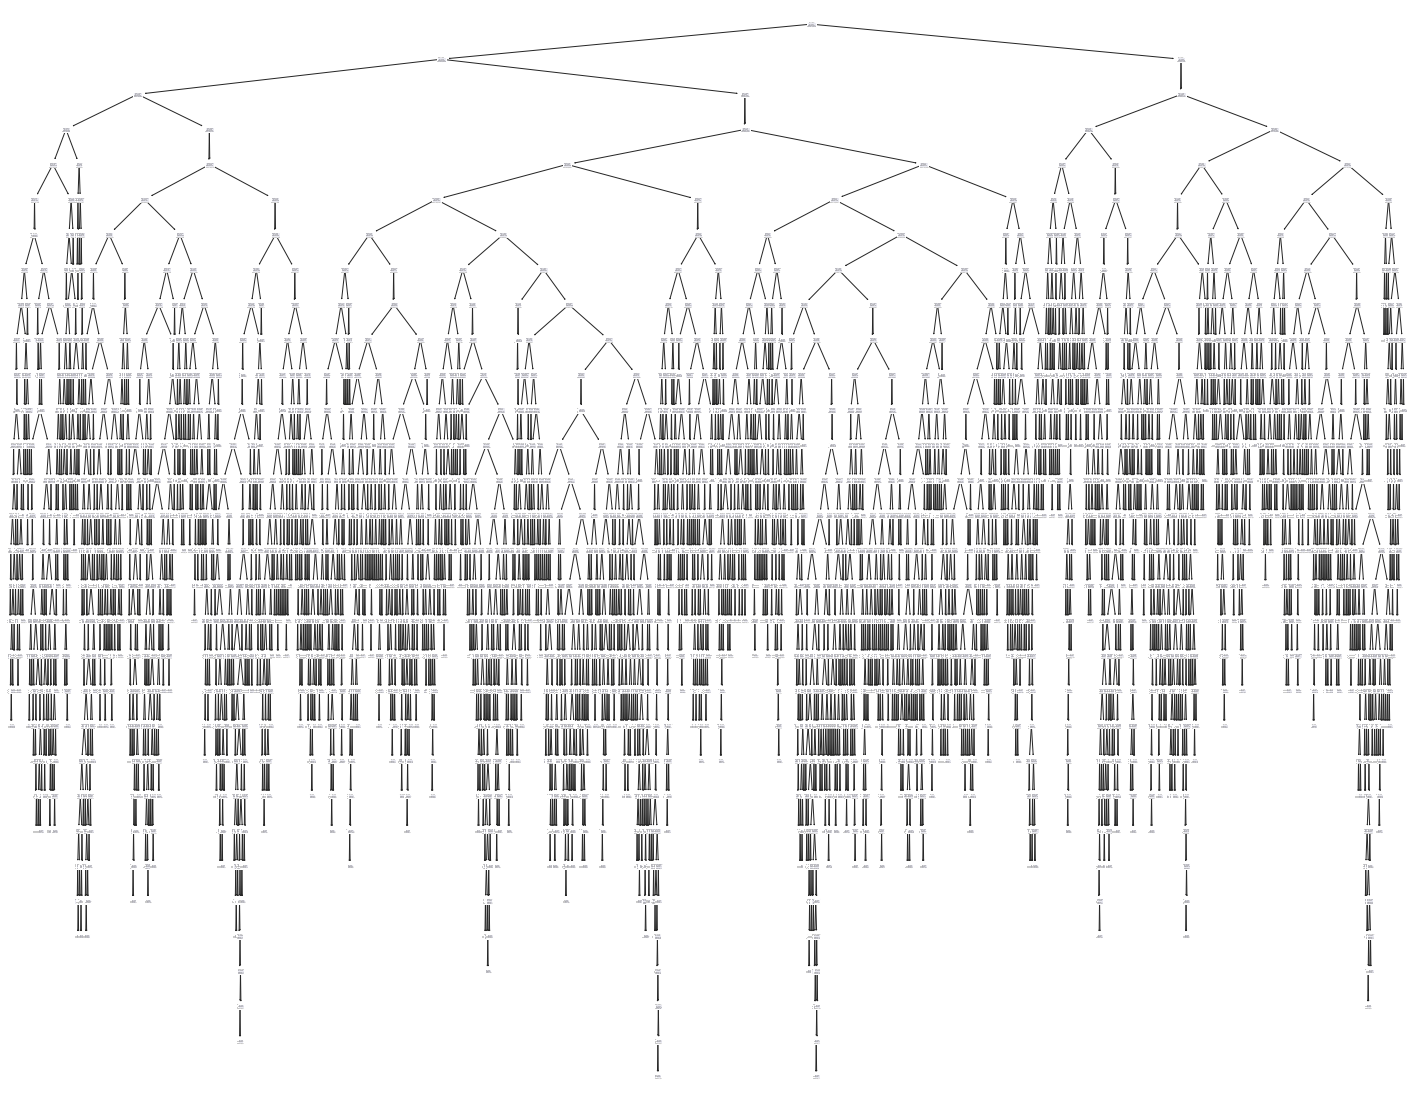

In [135]:
from sklearn import tree
plt.figure(figsize=(25,20))

tree.plot_tree(dtree)

#### Modele

In [136]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
model.fit(x_train, y_train)

print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_bagclass_smote = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_bagclass_smote)

accuracy: 0.7912709422687013
auroc: 0.5367242613145827


In [137]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(random_state=1)
model.fit(x_train, y_train)
model.score(x_test,y_test)

print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_adaboost_smote = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_adaboost_smote)

accuracy: 0.8169885817948992
auroc: 0.5206016580824543


In [138]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(x_train, y_train)
model.score(x_test,y_test)

print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_gradboost_smote = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_gradboost_smote)

accuracy: 0.8335289723615409
auroc: 0.5


In [139]:
import xgboost as xgb 
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(x_train, y_train)

print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_xgboost_smote = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_xgboost_smote)

[21:02:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kasia\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy: 0.8293671966705795
auroc: 0.5149455567263785


In [140]:
#podsumowanie modeli
prediction_data_smote={'Model':['Regresja Logistyczna',
                          'Drzewo Decyzyjne',
                          'BaggingClassifier',
                          'AdaBoostClassifier',
                          'GradientBoostingClassifier',
                          'XGBoost '
                         ],
                                    
                    'AUROC_S':[model_lreg_smote,
                              model_dtree_smote,
                              model_bagclass_smote,
                              model_adaboost_smote,
                              model_gradboost_smote,
                              model_xgboost_smote]
                    }
 
#ataFrame
prediction_table_smote = pd.DataFrame(prediction_data_smote)

#### Zestawienie wyników poszczególnych modeli przed i po balansowaniu zbioru treningowego

In [141]:
auroc_smote = [prediction_table_smote['AUROC_S']]
prediction_table = prediction_table.join(auroc_smote)
prediction_table['roznica'] = (prediction_table['AUROC_S'] - prediction_table['AUROC']).round(2)
prediction_table

Model     AUROC   AUROC_S  roznica
0        Regresja Logistyczna  0.505134  0.537336     0.03
1            Drzewo Decyzyjne  0.531249  0.541664     0.01
2           BaggingClassifier  0.529876  0.536724     0.01
3          AdaBoostClassifier  0.503934  0.520602     0.02
4  GradientBoostingClassifier  0.500000  0.500000     0.00
5                    XGBoost   0.501204  0.514946     0.01

#### Wniosek

Po pierwszym trenowaniu modeli uzyskane wyniki oscylowały w okolicach 50-53%. Zbalansowanie zbioru treningowego pozwoliło uzyskać nieznacznie wyższe wyniki, najwyższy: 54%. 

## SMOTE & PCA

In [142]:
#zbiór po skalowaniu, do PCA, kopia zapasowa
xPCAsm = X2.copy()

In [143]:
xPCAsm.shape

(31236, 43)

In [144]:
# Dzielenie danych na etykiety i atrybuty
x_pca = xPCAsm.drop(['loan_status'], axis = 1)
y_pca = xPCAsm['loan_status']

C:\Users\Kasia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loan_status', ylabel='count'>

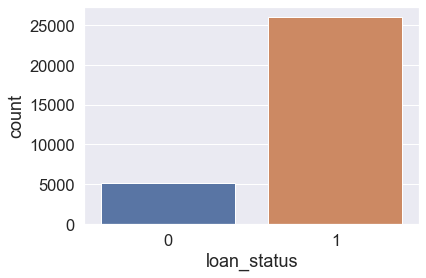

In [145]:
#sprawdzenie rozkładu zmiennej y przed balansowaniem zbioru
sns.countplot(y_pca)

In [146]:
#rozmiar zmiennej x przed balansowaniem
x_pca.shape

(31236, 42)

In [147]:
#SMOTE
from imblearn.over_sampling import SMOTE
#balansowanie zbioru
smote = SMOTE(random_state = 101)
x, y = smote.fit_resample(x_pca, y_pca)

In [148]:
#dataframe
xPCA_smote = pd.DataFrame(x, columns=x.columns)

In [149]:
xPCA_smote.shape

(52074, 42)

C:\Users\Kasia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loan_status', ylabel='count'>

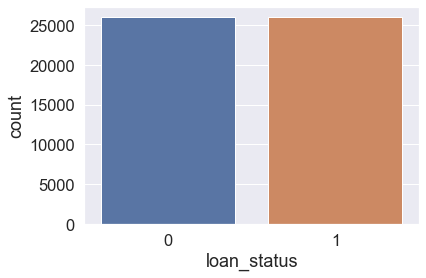

In [150]:
#sprawdzenie rozkładu zmiennej y po balansowaniu
sns.countplot(y)

In [151]:
#zmienna x po balansowaniu zbioru
x.shape

(52074, 42)

In [152]:
## PCA
## wykonanie standaryzacji przed zastosowaniem PCA
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [153]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(x_scaled)

PCA(random_state=42)

In [154]:
pca.explained_variance_ratio_.round(4)

array([0.1127, 0.0656, 0.0546, 0.0466, 0.0419, 0.0388, 0.0337, 0.0325,
       0.0311, 0.0273, 0.0251, 0.0247, 0.0246, 0.0244, 0.0242, 0.0241,
       0.024 , 0.0239, 0.0238, 0.0238, 0.0237, 0.0235, 0.0231, 0.0225,
       0.0207, 0.0181, 0.0178, 0.0172, 0.0168, 0.0143, 0.0136, 0.0115,
       0.0084, 0.0074, 0.0073, 0.007 , 0.0063, 0.0059, 0.0036, 0.0024,
       0.0015, 0.    ])

In [155]:
x.columns

Index(['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'delinq_amnt', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_bc_sats', 'num_sats',
       'pub_rec_bankruptcies', 'total_bal_ex_mort', 'fico_avg',
       'annual_inc_range', 'car', 'credit_card', 'debt_consolidation',
       'home_improvement', 'house', 'major_purchase', 'medical', 'moving',
       'other', 'renewable_energy', 'small_business', 'vacation', 'wedding',
       'success_score', 'insta_share'],
      dtype='object')

In [156]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.11265482, 0.17826161, 0.23286196, 0.2794312 , 0.32137337,
       0.36017926, 0.39385722, 0.42636196, 0.4574184 , 0.48475692,
       0.50987168, 0.53457309, 0.55916244, 0.58351793, 0.607694  ,
       0.63175516, 0.65579326, 0.67968917, 0.70351772, 0.72733064,
       0.75107084, 0.77460751, 0.79770226, 0.82024318, 0.84090741,
       0.85899308, 0.87682295, 0.89397516, 0.91076504, 0.92508629,
       0.93868038, 0.95021148, 0.958614  , 0.96600061, 0.97329906,
       0.98028147, 0.98653709, 0.99243034, 0.99603069, 0.99846071,
       0.99998686, 1.        ])

In [157]:
pca.components_[0]

array([ 0.28599782,  0.20251614,  0.17959875,  0.10407386,  0.11885601,
        0.25798739,  0.15540777,  0.1430695 ,  0.06514991, -0.20319938,
        0.05860159,  0.0562607 ,  0.33793645, -0.01858244,  0.27938176,
        0.08421786,  0.34742891,  0.00095946,  0.21164313, -0.02228937,
       -0.05410467,  0.22757406,  0.33776568, -0.01843996,  0.29137565,
       -0.02351428,  0.15944894, -0.0291909 , -0.00902408,  0.06015906,
       -0.005164  , -0.00458574, -0.03018225, -0.01269674, -0.02242426,
       -0.03820184, -0.00247438, -0.01001118, -0.01967597, -0.02346706,
       -0.02083462,  0.04293676])

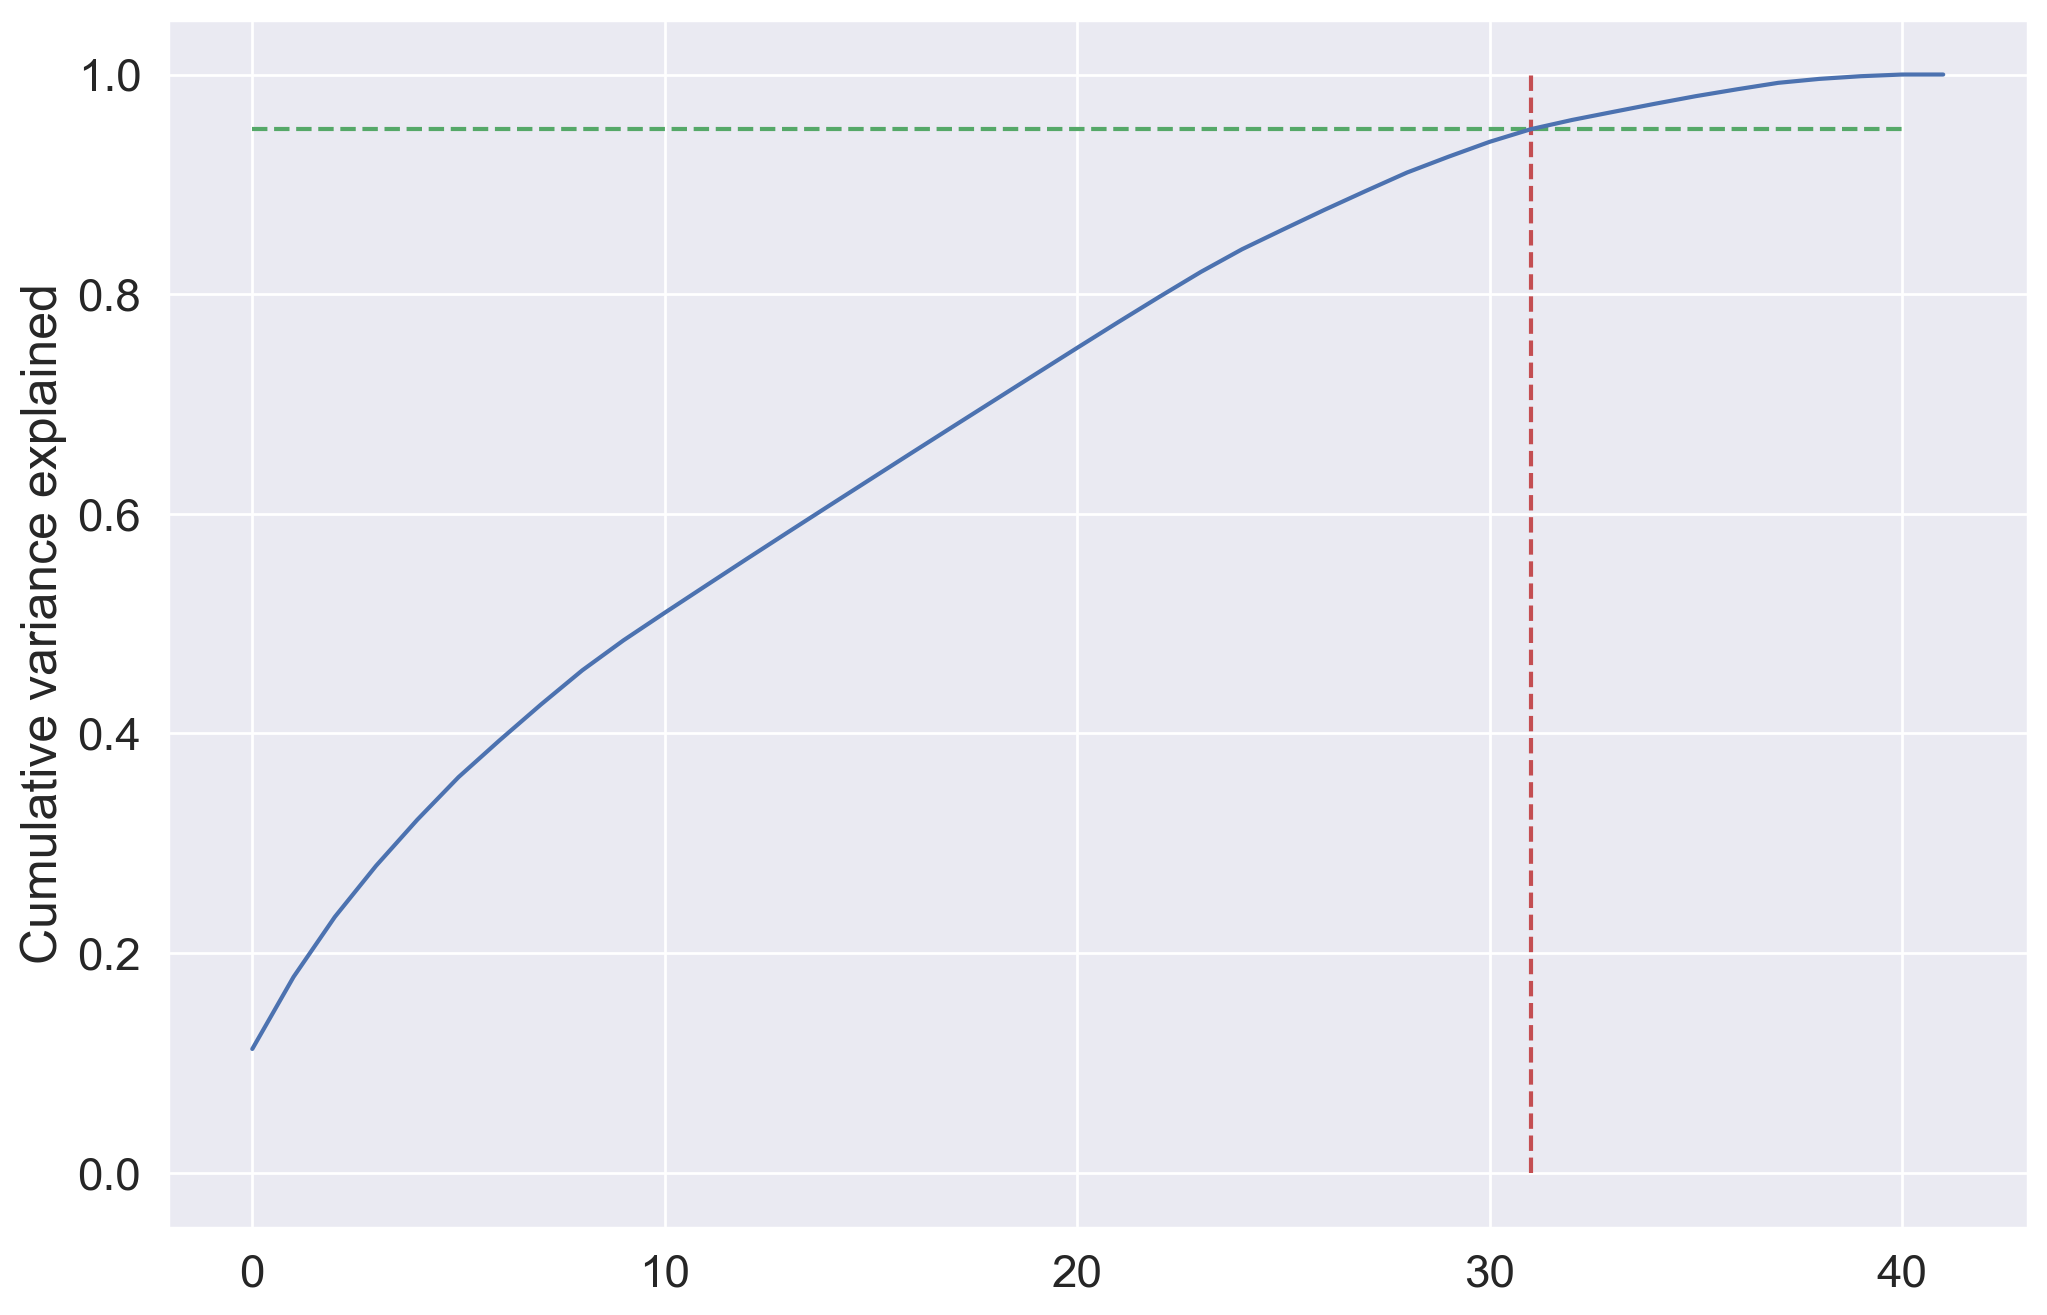

In [158]:
fig = plt.figure(figsize=[12,8],dpi=200)
plt.vlines(x=31, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=40, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [159]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=31)
x_pca_final = pca_final.fit_transform(x_scaled)

In [160]:
corrmat = np.corrcoef(x_pca_final.transpose())

In [161]:
corrmat.shape

(31, 31)

<AxesSubplot:>

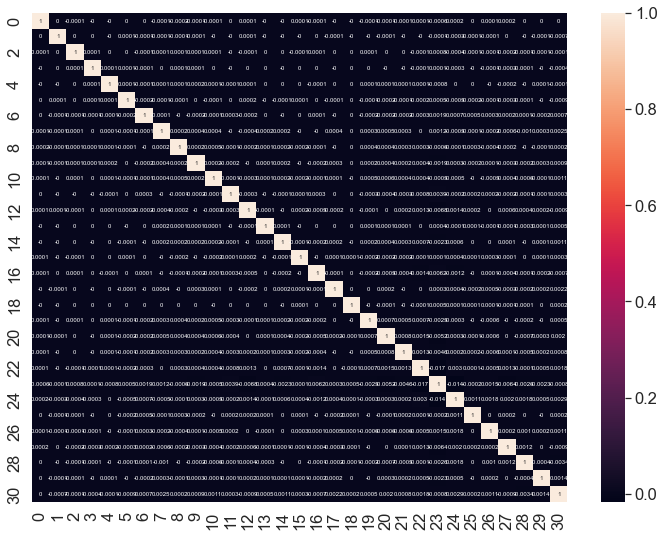

In [162]:
plt.figure(figsize=[12,9])
sns.heatmap(corrmat.round(4), annot=True, annot_kws={"size": 6})

In [163]:
pca_col = list(range(1,31+1))

In [164]:
x_pca_final_df = pd.DataFrame(x_pca_final,columns=pca_col)

In [165]:
x_pca_final_df.head(2)

1         2         3         4         5         6         7   \
0 -1.896075  1.742111  2.069710  0.459518  0.173548  1.253823  1.062236   
1  0.607796 -0.691092  0.143945  0.100210  0.261425 -0.439511  3.357252   

         8         9         10  ...        22        23        24        25  \
0 -1.020669 -0.549765 -0.027173  ... -0.865527  0.110762 -0.170763  0.262223   
1  1.765462  2.574075  0.207011  ...  0.295039 -0.162036 -0.121398  0.209079   

         26        27        28        29        30        31  
0 -0.015991 -0.118993 -0.331996 -0.497496 -0.498387  1.215615  
1  0.769428  0.534140 -0.404646  0.427704  0.230743  0.083735  

[2 rows x 31 columns]

In [166]:
x = x_pca_final_df

In [167]:
print("x: ",x.shape)
print("y: ",y.shape)

x:  (52074, 31)
y:  (52074,)


In [168]:
#podział na zbiór testowy i treningowy
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=100,test_size=0.3,stratify=y)

In [169]:
#sprawdzenie ilości zmiennych
print("x_train: ",x_train.shape)
print("x_test: ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

x_train:  (36451, 31)
x_test:  (15623, 31)
y_train:  (36451,)
y_test:  (15623,)


## Modelowanie po PCA oraz zbalansowaniu zbioru (SMOTE)

In [170]:
x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

print("x_train: ",x_train.shape)
print("x_test: ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

x_train:  (31, 36451)
x_test:  (31, 15623)
y_train:  (36451,)
y_test:  (15623,)


In [171]:
# dimension = 30
def initialize_weights_and_bias(dimension):
    
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w,b

In [172]:
def sigmoid(z):
    
    y_head = 1/(1+ np.exp(-z))
    return y_head

In [173]:
 def forward_backward_propagation(w,b,x_train,y_train):   
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]                 # x_train.shape[1]  is for scaling
    gradients = {"derivative_weight": derivative_weight, "derivative_bias": derivative_bias}
    
    return cost,gradients

In [174]:
def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    # updating(learning) parameters is number_of_iterarion times
    for i in range(number_of_iterarion):
        # make forward and backward propagation and find cost and gradients
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        # lets update
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 10 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
            
    # we update(learn) parameters weights and bias
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

In [175]:
def predict(w,b,x_test):
    # x_test is a input for forward propagation
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

In [176]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    # initialize
    dimension =  x_train.shape[0] 
    w,b = initialize_weights_and_bias(dimension)
    # do not change learning rate
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)

    # Print test Errors
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 2, num_iterations = 120)  

ValueError: Length of values (1) does not match length of index (36451)

In [177]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train.T,y_train.T)
print("test accuracy {}".format(lr.score(x_test.T,y_test.T)))

test accuracy 0.6924406324009473


In [178]:
print("accuracy:", lr.score(x_test.T,y_test.T))
prediction = lr.predict(x_test.T)
model_lreg_final = metrics.roc_auc_score(y_test.T,prediction)
print("auroc:", model_lreg_final)

accuracy: 0.6924406324009473
auroc: 0.6924388489246361


#### Drzewo decyzyjne

In [179]:
#przywrócenie zmiennych
x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

print("x_train: ",x_train.shape)
print("x_test: ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

x_train:  (36451, 31)
x_test:  (15623, 31)
y_train:  (36451,)
y_test:  (15623,)


In [180]:
dtree = DecisionTreeClassifier()

In [181]:
dtree.fit(x_train,y_train)

DecisionTreeClassifier()

In [182]:
def evaluate(prediction,y_test): 
    result = classification_report(y_test,prediction,output_dict=True)
    f1 = result['1']['f1-score']
    accuracy = result['accuracy']
    performance_data= {'f1-score':round(f1, 2),
                      'accuracy':round(accuracy, 2)}
    return performance_data

In [183]:
dt_prediction = dtree.predict(x_test)

In [184]:
print("accuracy:", dtree.score(x_test,y_test))
prediction = dtree.predict(x_test)
model_dtree_final = metrics.roc_auc_score(y_test,dt_prediction)
print("auroc:", model_dtree_final)

accuracy: 0.7309735646162708
auroc: 0.7309720926735394


#### Pozostałe modele

In [185]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
model.fit(x_train, y_train)
print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_bagclass_final = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_bagclass_final)

accuracy: 0.7846124303910901
auroc: 0.7846100655114825


In [186]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(random_state=1)
model.fit(x_train, y_train)
print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_adaboost_final = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_adaboost_final)

accuracy: 0.7549766370095372
auroc: 0.7549761443598092


In [187]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(x_train, y_train)
print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_gradboost_final = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_gradboost_final)

accuracy: 0.7271970812263969
auroc: 0.7271955969770467


In [188]:
import xgboost as xgb 
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(x_train, y_train)
print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_xgboost_final = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_xgboost_final)

[21:04:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kasia\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


accuracy: 0.7575369647314857
auroc: 0.7575371194259568


In [189]:
#podsumowanie modeli
prediction_data_final={'Model':['Regresja Logistyczna',
                          'Drzewo Decyzyjne',
                          'BaggingClassifier',
                          'AdaBoostClassifier',
                          'GradientBoostingClassifier',
                          'XGBoost '
                         ],
                                    
                   'AUROC_Final':[model_lreg_final,
                              model_dtree_final,
                              model_bagclass_final,
                              model_adaboost_final,
                              model_gradboost_final,
                              model_xgboost_final]
                    }
 
#DataFrame
prediction_table_final = pd.DataFrame(prediction_data_final)

In [190]:
auroc_final = [prediction_table_final['AUROC_Final']]
prediction_table = prediction_table.join(auroc_final)
prediction_table['roznica_final'] = (prediction_table['AUROC_Final'] - prediction_table['AUROC_S']).round(2)
prediction_table

Model     AUROC   AUROC_S  roznica  AUROC_Final  \
0        Regresja Logistyczna  0.505134  0.537336     0.03     0.692439   
1            Drzewo Decyzyjne  0.531249  0.541664     0.01     0.730972   
2           BaggingClassifier  0.529876  0.536724     0.01     0.784610   
3          AdaBoostClassifier  0.503934  0.520602     0.02     0.754976   
4  GradientBoostingClassifier  0.500000  0.500000     0.00     0.727196   
5                    XGBoost   0.501204  0.514946     0.01     0.757537   

   roznica_final  
0           0.16  
1           0.19  
2           0.25  
3           0.23  
4           0.23  
5           0.24

# Finalny model 

In [191]:
#Wybrany model

from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
model.fit(x_train, y_train)
print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_bagclass_final = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_bagclass_final)

accuracy: 0.7821801190552391
auroc: 0.7821780491531793


#### Trenowanie Modelu

In [192]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
knn_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])
params = [{'knn__n_neighbors': [3, 5, 7, 9],
         'knn__weights': ['uniform', 'distance'],
         'knn__leaf_size': [15, 20]}]
gs_knn = GridSearchCV(knn_pipe,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
gs_knn.fit(x_train, y_train)
gs_knn.best_params_

# find best model score
gs_knn.score(x_train, y_train)


1.0

In [193]:
params

[{'knn__n_neighbors': [3, 5, 7, 9],
  'knn__weights': ['uniform', 'distance'],
  'knn__leaf_size': [15, 20]}]

In [194]:
gs_knn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mms', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__leaf_size': [15, 20],
                          'knn__n_neighbors': [3, 5, 7, 9],
                          'knn__weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [195]:
#ponowne sprawdzenie modelu

from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
model.fit(x_train, y_train)
print("accuracy:", model.score(x_test,y_test))
prediction = model.predict(x_test)
model_bagclass_final = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_bagclass_final)

accuracy: 0.7842283812327978
auroc: 0.7842261228748854


In [196]:
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import learning_curve
def rmse_cv(model, cv=13):
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = cv))
    return rmse

In [197]:
from sklearn.linear_model import LinearRegression

linearModel = LinearRegression()
rmse = rmse_cv(linearModel)
print("RMSE estimate: {}, std: {}".format(rmse.mean(), rmse.std()))

RMSE estimate: 0.4516645809335703, std: 0.0031644610597976346


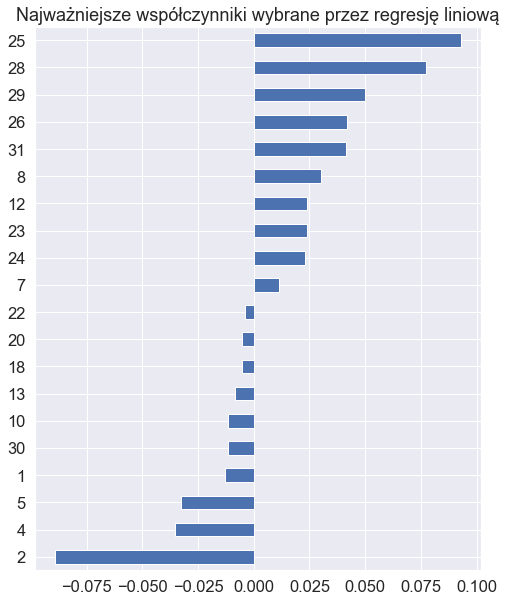

In [198]:
from matplotlib import rcParams
linearModel.fit(x_train, y_train)

coef = pd.Series(linearModel.coef_, index = x.columns)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Najważniejsze współczynniki wybrane przez regresję liniową")
plt.show()

In [199]:
x_train_rc = x_train.drop([2], axis = 1)

In [200]:
x_train_rc.head()

1         3         4         5         6         7         8   \
51260 -1.755994  0.674182  0.579689  0.928847  1.313263 -0.830354 -1.006569   
18507 -0.319723 -1.062859 -0.335254  1.195168 -3.678815  0.888422  0.441988   
17242  3.329001  1.493039  0.700256  0.663207 -0.275870  0.670460  3.251890   
27983  1.227464 -2.450158  0.296098  1.128975  0.417015 -0.424811  1.126575   
26661 -0.668464 -0.006354 -1.277543 -0.546848 -0.286309 -0.479296 -2.269139   

             9         10        11  ...        22        23        24  \
51260  0.080857 -0.291856 -0.044018  ... -0.396846 -0.127583 -0.028199   
18507  0.658236 -0.080041  0.262134  ...  0.279232 -1.027637 -0.135746   
17242 -1.347777  1.392314 -0.539950  ... -0.301509  1.324236  0.317416   
27983  0.709012 -0.872849  0.393274  ... -0.737102  1.073382  0.298268   
26661  1.008442 -1.010386  0.050236  ... -0.464834 -0.071792  0.128304   

             25        26        27        28        29        30        31  
51260 -0.221029 -0.743430  0.243157  0.172017  0.375763  0.337725 -0.571270  
18507  1.109466  0.386443 -0.270331 -2.087651 -1.254800 -0.757940 -0.513880  
17242 -1.711345 -0.307684 -0.706419  0.689608  1.131049  1.942546  0.160682  
27983 -0.682580  0.875159 -2.328198 -0.303132  0.602260  1.272629 -0.173115  
26661  1.147401 -1.222770  0.130751 -0.537884  0.643093 -0.485200  0.262232  

[5 rows x 30 columns]

In [201]:
x_test_rc = x_test.drop([2], axis = 1)

In [202]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
model.fit(x_train_rc, y_train)
print("accuracy:", model.score(x_test_rc,y_test))
prediction = model.predict(x_test_rc)
model_bagclass_final_rc = metrics.roc_auc_score(y_test,prediction)
print("auroc:", model_bagclass_final_rc)

accuracy: 0.7800038404915829
auroc: 0.7800016968337286


In [203]:
#learning curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [204]:
print("x: ",x.shape)
print("y: ",y.shape)

x:  (52074, 31)
y:  (52074,)


In [205]:
## żródło: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :param train_sizes:
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [206]:
# Shuffle for learning curves
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

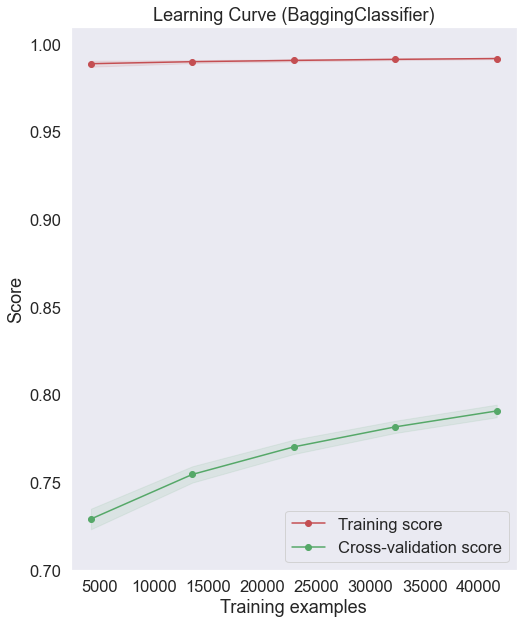

In [207]:
plot_learning_curve(model, 'Learning Curve (BaggingClassifier)', x, y, (0.7, 1.01), cv=cv, n_jobs=4)
plt.show()